In [14]:
# Standard library
import os
import sys
import re
import json
import pickle
import glob
import ast
import warnings
from pathlib import Path
import importlib

# Add custom path
sys.path.append('/root/capsule/code/beh_ephys_analysis')

# Scientific libraries
import numpy as np
import pandas as pd
import xarray as xr
import scipy.signal as signal
from scipy import stats
from statsmodels.stats.multitest import multipletests
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Plotting
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
from matplotlib.lines import Line2D
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colormaps
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# SpikeInterface
import spikeinterface.full as si
import spikeinterface.extractors as se
import spikeinterface.preprocessing as spre
import spikeinterface.postprocessing as spost
import spikeinterface.widgets as sw

# Progress bar
from tqdm import tqdm

# IPython display
from IPython.display import clear_output

# Open Ephys
from open_ephys.analysis import Session

# AIND analysis and utils
from aind_dynamic_foraging_basic_analysis.licks.lick_analysis import load_nwb
from aind_dynamic_foraging_data_utils.nwb_utils import load_nwb_from_filename
from aind_ephys_utils import align, sort

# Local utilities
import utils.analysis_funcs as af
import utils.plotting_funcs as pf
from utils.beh_functions import session_dirs
# from utils.plot_utils import shiftedColorMap, template_reorder, plot_raster_bar, merge_pdfs

# Warnings
warnings.filterwarnings("ignore")

# Matplotlib inline for Jupyter
%matplotlib inline

# Confirm version
print(si.__version__)
print('Finished loading packages')


0.102.1
Finished loading packages


In [15]:
# combined_data_folder = '/data/combined/'
scratch_data_folder = '/root/capsule/data/LC-NE_scratch_data_06-14-2025/'
combined_unit_tbl_folder = os.path.join(scratch_data_folder, "combined/combine_unit_tbl")
combined_unit_pkl_file_path = os.path.join(combined_unit_tbl_folder, "combined_unit_tbl.pkl")

# Load the pickle file
unit_data = pd.read_pickle(combined_unit_pkl_file_path)

# If the data is not already a DataFrame, you can convert it
if not isinstance(unit_data, pd.DataFrame):
    unit_tbl = pd.DataFrame(unit_data)
else:
    unit_tbl = unit_data

opto_units = unit_tbl.query("opto_tagged == True & qc_pass == True")["unit"].to_list()
opto_unit_tbl = unit_tbl[(unit_tbl['opto_tagged'] == True) & (unit_tbl['qc_pass'] == True)]
opto_units = opto_unit_tbl['unit'].to_list()
print(f"Number of opto units: {len(opto_units)}")
# unit_tbl
header = unit_tbl.columns.tolist()
print(header)

Number of opto units: 420
['session', 'unit', 'qc_pass', 'opto_tagged', 'opto_tagging_pre', 'opto_tagging_post', 'anti', 'in_df', 'trial_count', 'p_max', 'lat_max_p', 'isi_violations', 'snr', 'eu', 'corr', 'probe', 'y_loc', 'rec_side', 'top', 'bottom']


In [16]:
## data organization for antidromic stimulation analysis
# Regular expression to match the folder name pattern
pattern = re.compile(r'^(ecephys|behavior)_\d+_\d{4}-\d{2}-\d{2}_\d{2}-\d{2}-\d{2}$')
# Walk through the directory
data = []
for root, dirs, files in os.walk(scratch_data_folder):
    for dirname in dirs:
        if pattern.match(dirname):
            session = dirname
            session_id = "_".join(session.split("_")[1:3])
            session_path = os.path.join(root, dirname)

            summary_filename = f"{session}_curated_soma_opto_tagging_summary.pkl"
            summary_path = os.path.join(session_path, "ephys", "opto", "curated", summary_filename)
            summary_exists = os.path.exists(summary_path)

            opto_session_filename = f"{session}_opto_session.csv" 
            opto_session_path = os.path.join(session_path, "ephys", "opto", "curated", opto_session_filename)            
            opto_session_exists = os.path.exists(opto_session_path)

            spiketimes_filename = f"spiketimes.pkl"
            spiketimes_path = os.path.join(session_path, "ephys", "curated", "processed", spiketimes_filename)
            spiketimes_exists = os.path.exists(spiketimes_path)          

            data.append({
                'session': session,
                'session_id': session_id,
                'session_path': session_path,
                'summary_file_path': summary_path,
                'summary_exists': summary_exists,
                'opto_session_file_path': opto_session_path,
                'opto_session_exists': opto_session_exists,                
                'spiketimes_file_path': spiketimes_path,
                'spiketimes_exists': spiketimes_exists,                
            })

# Create DataFrame
df = pd.DataFrame(data)
result_folder = '/scratch/antidromic'

# Display the DataFrame
df.to_csv(os.path.join(result_folder, 'session_summary.csv'), index=False)


In [17]:
df

session         session_id  \
0   behavior_751766_2025-02-13_11-31-21  751766_2025-02-13   
1   behavior_751766_2025-02-11_11-53-38  751766_2025-02-11   
2   behavior_751766_2025-02-14_11-37-11  751766_2025-02-14   
3   behavior_751766_2025-02-15_12-08-11  751766_2025-02-15   
4   behavior_754897_2025-03-12_12-23-15  754897_2025-03-12   
5   behavior_754897_2025-03-11_12-07-41  754897_2025-03-11   
6   behavior_754897_2025-03-14_11-28-53  754897_2025-03-14   
7   behavior_754897_2025-03-13_11-20-42  754897_2025-03-13   
8   behavior_754897_2025-03-15_11-32-18  754897_2025-03-15   
9   behavior_716325_2024-05-31_10-31-14  716325_2024-05-31   
10  behavior_716325_2024-05-29_10-33-32  716325_2024-05-29   
11  behavior_716325_2024-05-30_11-33-46  716325_2024-05-30   
12   ecephys_691893_2023-10-05_12-46-57  691893_2023-10-05   
13   ecephys_691893_2023-10-06_13-48-18  691893_2023-10-06   
14   ecephys_713854_2024-03-08_16-20-33  713854_2024-03-08   
15   ecephys_713854_2024-03-05_13-31-20  713854_2024-03-05   
16   ecephys_713854_2024-03-08_17-15-58  713854_2024-03-08   
17   ecephys_713854_2024-03-05_13-01-09  713854_2024-03-05   
18   ecephys_713854_2024-03-08_14-54-25  713854_2024-03-08   
19   ecephys_713854_2024-03-05_12-01-40  713854_2024-03-05   
20   ecephys_713854_2024-03-08_15-43-01  713854_2024-03-08   
21  behavior_758017_2025-02-05_11-42-34  758017_2025-02-05   
22  behavior_758017_2025-02-07_14-11-08  758017_2025-02-07   
23  behavior_758017_2025-02-04_11-57-38  758017_2025-02-04   
24  behavior_758017_2025-02-06_11-26-14  758017_2025-02-06   
25   ecephys_717120_2024-03-06_12-54-27  717120_2024-03-06   
26   ecephys_717120_2024-03-07_12-12-02  717120_2024-03-07   
27   ecephys_717120_2024-03-06_12-23-53  717120_2024-03-06   
28   ecephys_684930_2023-09-27_10-04-04  684930_2023-09-27   
29   ecephys_684930_2023-09-28_11-45-27  684930_2023-09-28   
30   ecephys_684930_2023-09-28_12-44-15  684930_2023-09-28   
31  behavior_751004_2024-12-21_13-28-28  751004_2024-12-21   
32  behavior_751004_2024-12-19_11-50-37  751004_2024-12-19   
33  behavior_751004_2024-12-23_14-20-03  751004_2024-12-23   
34  behavior_751004_2024-12-22_13-09-17  751004_2024-12-22   
35  behavior_751004_2024-12-20_13-26-11  751004_2024-12-20   
36  behavior_761038_2025-04-16_10-39-10  761038_2025-04-16   
37  behavior_761038_2025-04-18_12-37-39  761038_2025-04-18   
38  behavior_761038_2025-04-17_11-03-16  761038_2025-04-17   
39  behavior_761038_2025-04-15_10-25-11  761038_2025-04-15   
40   ecephys_763360_2025-04-15_12-16-29  763360_2025-04-15   
41  behavior_758018_2025-03-21_11-00-34  758018_2025-03-21   
42  behavior_758018_2025-03-19_11-16-44  758018_2025-03-19   
43  behavior_758018_2025-03-20_11-53-05  758018_2025-03-20   
44  behavior_751769_2025-01-17_11-37-39  751769_2025-01-17   
45  behavior_751769_2025-01-16_11-32-05  751769_2025-01-16   
46  behavior_751769_2025-01-18_10-15-25  751769_2025-01-18   
47  behavior_752014_2025-03-28_11-04-59  752014_2025-03-28   
48  behavior_752014_2025-03-25_12-09-20  752014_2025-03-25   
49  behavior_752014_2025-03-27_12-03-59  752014_2025-03-27   
50  behavior_752014_2025-03-26_11-18-57  752014_2025-03-26   
51  behavior_717121_2024-06-15_10-00-58  717121_2024-06-15   
52   ecephys_687697_2023-09-15_11-30-06  687697_2023-09-15   
53   ecephys_687697_2023-09-15_12-36-06  687697_2023-09-15   
54  behavior_751181_2025-02-25_12-12-35  751181_2025-02-25   
55  behavior_751181_2025-02-26_11-51-19  751181_2025-02-26   
56  behavior_751181_2025-02-27_11-24-47  751181_2025-02-27   

                                         session_path  \
0   /root/capsule/data/LC-NE_scratch_data_06-14-20...   
1   /root/capsule/data/LC-NE_scratch_data_06-14-20...   
2   /root/capsule/data/LC-NE_scratch_data_06-14-20...   
3   /root/capsule/data/LC-NE_scratch_data_06-14-20...   
4   /root/capsule/data/LC-NE_scratch_data_06-14-20...   
5   /root/capsule/data/LC-NE_scratch_data_06-14-20...   
6   /root/capsule/data/LC-NE_scratch

In [4]:
# Load antidromic unit table
df = pd.read_csv(os.path.join(result_folder, 'session_summary.csv'))

result_folder = '/scratch/antidromic'
antidromic_unit_tbl_path = os.path.join(result_folder, 'antidromic_units.csv')
antidromic_unit_tbl = pd.read_csv(antidromic_unit_tbl_path)
antidromic_unit_tbl

session  unit_id projection  tier
0   behavior_751766_2025-02-13_11-31-21       23         S1     2
1   behavior_751766_2025-02-13_11-31-21       24         S1     2
2   behavior_751766_2025-02-13_11-31-21       31         S1     2
3   behavior_751766_2025-02-11_11-53-38       44         S1     3
4   behavior_751766_2025-02-14_11-37-11       36         S1     3
..                                  ...      ...        ...   ...
71  behavior_751181_2025-02-27_11-24-47       46        PrL     1
72  behavior_751181_2025-02-27_11-24-47       44         S1     2
73  behavior_751181_2025-02-27_11-24-47       46         S1     1
74  behavior_751181_2025-02-27_11-24-47       57         S1     2
75  behavior_751181_2025-02-27_11-24-47       62         S1     1

[76 rows x 4 columns]

In [5]:
antidromic_unit_tbl_spikes = antidromic_unit_tbl.copy()
antidromic_unit_tbl_spikes["emission_location"] = None
antidromic_unit_tbl_spikes["unit_spiketimes"] = None
antidromic_unit_tbl_spikes["num_pulses"] = None
antidromic_unit_tbl_spikes["pulse_interval"] = None
antidromic_unit_tbl_spikes["duration"] = None
antidromic_unit_tbl_spikes["event_onsets"] = None


In [6]:
antidromic_unit_tbl_spikes

session  unit_id projection  tier  \
0   behavior_751766_2025-02-13_11-31-21       23         S1     2   
1   behavior_751766_2025-02-13_11-31-21       24         S1     2   
2   behavior_751766_2025-02-13_11-31-21       31         S1     2   
3   behavior_751766_2025-02-11_11-53-38       44         S1     3   
4   behavior_751766_2025-02-14_11-37-11       36         S1     3   
..                                  ...      ...        ...   ...   
71  behavior_751181_2025-02-27_11-24-47       46        PrL     1   
72  behavior_751181_2025-02-27_11-24-47       44         S1     2   
73  behavior_751181_2025-02-27_11-24-47       46         S1     1   
74  behavior_751181_2025-02-27_11-24-47       57         S1     2   
75  behavior_751181_2025-02-27_11-24-47       62         S1     1   

   emission_location unit_spiketimes num_pulses pulse_interval duration  \
0               None            None       None           None     None   
1               None            None       None           None     None   
2               None            None       None           None     None   
3               None            None       None           None     None   
4               None            None       None           None     None   
..               ...             ...        ...            ...      ...   
71              None            None       None           None     None   
72              None            None       None           None     None   
73              None            None       None           None     None   
74              None            None       None           None     None   
75              None            None       None           None     None   

   event_onsets  
0          None  
1          None  
2          None  
3          None  
4          None  
..          ...  
71         None  
72         None  
73         None  
74         None  
75         None  

[76 rows x 10 columns]

In [7]:
tag_trials["time"].tolist()

NameError: name 'tag_trials' is not defined

In [20]:
# Make antidromic_unit_tbl_spikes table
for i, row in antidromic_unit_tbl_spikes.head(3).iterrows():
    roi_session = row['session']
    roi_unit = row["unit_id"]
    roi_emission_location = row["projection"]
    roi_emission_location_str = f"surface_{roi_emission_location}"

    print(f"Processing session {roi_session} and unit {roi_unit}")

    # Add emission location info
    antidromic_unit_tbl_spikes.at[i, "emission_location"] = roi_emission_location_str

    session_df = df.query(f"session == '{roi_session}'")
    if session_df.empty:
        print(f"No session found for {roi_session}")
        continue

    # Load summary file
    summary_file_path = session_df["summary_file_path"].values[0]
    try:
        summary_pkl_file = pd.read_pickle(summary_file_path)
    except Exception as e:
        print(f"Failed to load summary file for session {roi_session}: {e}")
        continue

    # Load opto session file
    opto_path = session_df["opto_session_file_path"].values[0]
    if not opto_path:
        print(f"Opto session file does not exist for session {roi_session}")
        continue
    try:
        event_ids = pd.read_csv(opto_path)
    except Exception as e:
        print(f"Error reading opto session file: {e}")
        continue

    # Load spike times
    spiketimes_path = session_df["spiketimes_file_path"].values[0]
    if not spiketimes_path:
        print(f"Spiketimes file does not exist for session {roi_session}")
        continue
    try:
        spiketimes = pd.read_pickle(spiketimes_path)
    except Exception as e:
        print(f"Error loading spiketimes file: {e}")
        continue

    if roi_unit not in spiketimes or not isinstance(spiketimes[roi_unit], (list, np.ndarray, pd.Series)):
        print(f"Spiketimes for unit {roi_unit} not found or invalid in session {roi_session}")
        continue

    # Add unit spike times
    antidromic_unit_tbl_spikes.at[i, "unit_spiketimes"] = spiketimes[roi_unit]

    # Filter tagging trials
    # try:
    tag_trials = event_ids.query("site == @roi_emission_location_str")
    antidromic_unit_tbl_spikes.at[i, "num_pulses"] = tag_trials["num_pulses"].unique()[0]
    antidromic_unit_tbl_spikes.at[i, "pulse_interval"] = tag_trials["pulse_interval"].unique()[0]
    antidromic_unit_tbl_spikes.at[i, "duration"] = tag_trials["duration"].unique()[0]
    antidromic_unit_tbl_spikes.at[i, "event_onsets"] = tag_trials["time"].tolist()
    # except Exception as e:
    #     print(f"Error processing tag trials for session {roi_session}, unit {roi_unit}: {e}")
    #     continue

Processing session behavior_751766_2025-02-13_11-31-21 and unit 23
Processing session behavior_751766_2025-02-13_11-31-21 and unit 24
Processing session behavior_751766_2025-02-13_11-31-21 and unit 31


In [23]:
antidromic_unit_tbl_spikes

session  unit_id projection  tier  \
0   behavior_751766_2025-02-13_11-31-21       23         S1     2   
1   behavior_751766_2025-02-13_11-31-21       24         S1     2   
2   behavior_751766_2025-02-13_11-31-21       31         S1     2   
3   behavior_751766_2025-02-11_11-53-38       44         S1     3   
4   behavior_751766_2025-02-14_11-37-11       36         S1     3   
..                                  ...      ...        ...   ...   
71  behavior_751181_2025-02-27_11-24-47       46        PrL     1   
72  behavior_751181_2025-02-27_11-24-47       44         S1     2   
73  behavior_751181_2025-02-27_11-24-47       46         S1     1   
74  behavior_751181_2025-02-27_11-24-47       57         S1     2   
75  behavior_751181_2025-02-27_11-24-47       62         S1     1   

   emission_location                                    unit_spiketimes  \
0         surface_S1  [4750367.138526618, 4750367.315959893, 4750367...   
1         surface_S1  [4750367.146926614, 4750367.191826601, 4750367...   
2         surface_S1  [4750367.413359862, 4750367.984493012, 4750368...   
3         surface_S1  [4578898.8996774005, 4578899.400143669, 457890...   
4         surface_S1  [4837117.504110261, 4837117.686710209, 4837117...   
..               ...                                                ...   
71              None                                               None   
72              None                                               None   
73              None                                               None   
74              None                                               None   
75              None                                               None   

   num_pulses pulse_interval duration  \
0           5            195        5   
1           5            195        5   
2           5            195        5   
3           5            195        5   
4           5            195        5   
..        ...            ...      ...   
71       None           None     None   
72       None           None     None   
73       None           None     None   
74       None           None     None   
75       None           None     None   

                                         event_onsets  
0   [4754865.75396555, 4754867.904276237, 4754870....  
1   [4754865.75396555, 4754867.904276237, 4754870....  
2   [4754865.75396555, 4754867.904276237, 4754870....  
3   [4583412.255104841, 4583414.641076714, 4583417...  
4   [4842241.877145617, 4842244.149746566, 4842246...  
..                                                ...  
71                                               None  
72                                               None  
73                                               None  
74                                               None  
75                                               None  

[76 rows x 10 columns]

In [21]:
# save antidromic unit with spikes table
antidromic_unit_tbl_spikes.to_pickle(path=os.path.join(result_folder, 'antidromic_unit_tbl_spikes.pkl'))

In [ ]:
# load antidromic unit with spikes table


In [12]:
# plot antidromic raster
def plot_antidromic_raster(event_onsets, unit_spiketimes, time_range_raster, num_pulses, pulse_interval, duration):
    
    fig = plt.figure(figsize=(4, 6))  # Single unit, single site
    gs = gridspec.GridSpec(4, 1, height_ratios=[3, 6, 2, 0.5], hspace=0.8)

    int_event_locked_timestamps = []
    pulse_nums = []

    for pulse_num in range(num_pulses):
        time_shift = pulse_num * (duration + pulse_interval) / 1000  # Convert ms to sec
        shifted_range = time_range_raster + time_shift

        locked_spikes = af.event_locked_timestamps(
            unit_spiketimes, event_onsets, shifted_range, time_shift=time_shift
        )
        int_event_locked_timestamps.extend(locked_spikes)
        pulse_nums.extend([pulse_num + 1] * len(locked_spikes))

    # Raster plot
    ax_raster = fig.add_subplot(gs[0])
    pf.raster_plot(int_event_locked_timestamps, time_range_raster, cond_each_trial=pulse_nums, ms=100, ax=ax_raster)

    y_lims = np.array(ax_raster.get_ylim())
    ax_raster.add_patch(
        patches.Rectangle((0, y_lims[0]), duration / 1000, y_lims[1] - y_lims[0],
                          linewidth=1, edgecolor='tomato', facecolor='tomato', alpha=0.2)
    )
    ax_raster.set_ylabel('Pulse #')
    ax_raster.set_xlim(time_range_raster)
    ax_raster.set_title('Antidromic Raster')

    # return fig, int_event_locked_timestamps


    # Sorted raster
    ax_sorted = fig.add_subplot(gs[1], sharex=ax_raster)
    sorted_trials = sorted(int_event_locked_timestamps, key=lambda x: (len(x) == 0, x[0] if len(x) > 0 else np.inf))
    pf.raster_plot(sorted_trials, time_range_raster)
    y_lims = np.array(ax_sorted.get_ylim())
    ax_sorted.add_patch(
        patches.Rectangle((0, y_lims[0]), duration / 1000, y_lims[1] - y_lims[0],
                          linewidth=1, edgecolor='tomato', facecolor='tomato', alpha=0.2)
    )
    ax_sorted.set_ylabel('Sorted Trials')
    ax_sorted.set_xlim(time_range_raster)


    # PSTH
    ax_psth = fig.add_subplot(gs[2], sharex=ax_raster)
    psth, _, bins = pf.psth(int_event_locked_timestamps, time_range_raster, bin_size=0.003, smooth_window_size=3)
    ax_psth.plot(bins, psth, color='k')
    ax_psth.set_ylabel('PSTH')
    ax_psth.set_xlim(time_range_raster)
    ax_psth.set_xlabel('Time (s)')

    fig.tight_layout()
    plt.show()

    return fig, int_event_locked_timestamps 

time_range_raster = np.array([-100 / 1000, 70 / 1000])


roi_antidromic_unit_tbl_spikes = antidromic_unit_tbl_spikes.query("tier == 1")
for i, row in roi_antidromic_unit_tbl_spikes.iterrows():
    unit_spiketimes = row["unit_spiketimes"]
    num_pulses = row["num_pulses"]
    pulse_interval = row["pulse_interval"]
    duration = row["duration"]
    event_onsets = row["event_onsets"]

    print(f"Processing session {row['session']} and unit {row['unit_id']} and site {row['emission_location']} with {num_pulses} pulses and {pulse_interval} ms interval and {duration} ms duration")
    try:
        fig, int_event_locked_timestamps = plot_antidromic_raster(event_onsets, unit_spiketimes, time_range_raster, num_pulses, pulse_interval, duration)
    except Exception as e:
        
    fig.suptitle('Antidromic Raster Plot for Unit {}'.format(row["unit_id"]))

# int_event_locked_timestamp = 


IndentationError: expected an indented block after 'except' statement on line 76 (2438530583.py, line 78)

In [14]:
def cal_antidromic_latency(trials):
    # Step 1: Flatten and collect all positive values

    positive_values = [x for arr in trials for x in arr if x > 0]

    # Step 2: Histogram with fixed bin size
    bin_size = 0.003
    min_val = min(positive_values)
    max_val = max(positive_values)
    bins = np.arange(min_val, max_val + bin_size, bin_size)

    hist, bin_edges = np.histogram(positive_values, bins=bins)
    peak_bin_index = np.argmax(hist)
    peak_value = (bin_edges[peak_bin_index] + bin_edges[peak_bin_index + 1]) / 2

    print(f"Peak of positive value distribution: {peak_value:.5f} seconds")

    # Optional: Plot the histogram
    plt.hist(positive_values, bins=bins, color='skyblue', edgecolor='black')
    plt.axvline(peak_value, color='red', linestyle='--', label=f'Peak ≈ {peak_value:.3f}s')
    plt.title("Histogram of Positive Spike Times")
    plt.xlabel("Spike Time (s)")
    plt.ylabel("Count")
    plt.legend()
    plt.show()

    return peak_value

antidromic_latency = cal_antidromic_latency(int_event_locked_timestamps)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu

# --- Helper Function ---
def avg_y_over_x(x, y, bin_size):
    edges = np.arange(np.min(x), np.max(x) + bin_size, bin_size)
    bin_centers = (edges[:-1] + edges[1:]) / 2
    avg_y, sem_y = [], []

    for i in range(len(bin_centers)):
        bin_y = y[(x >= edges[i]) & (x < edges[i + 1])]
        if bin_y.size > 0:
            avg_y.append(np.nanmean(bin_y))
            sem_y.append(np.nanstd(bin_y) / np.sqrt(bin_y.size))
        else:
            avg_y.append(np.nan)
            sem_y.append(np.nan)

    return pd.DataFrame({'x': bin_centers, 'y': avg_y, 'sem': sem_y}), edges

# --- Input Data ---
ROI_sorted_data = int_event_locked_timestamps
antidromic_jitter = 0.005

# --- Step 1: Find antidromic latency (mode of first post-stim spike times) ---
first_spikes = [spikes[spikes > 0][0] for spikes in ROI_sorted_data if spikes.size > 0 and np.any(spikes > 0)]
hist, bin_edges = np.histogram(first_spikes, bins=100)
antidromic_latency = (bin_edges[np.argmax(hist)] + bin_edges[np.argmax(hist)+1]) / 2

# Plot histogram
plt.figure(figsize=(6, 4))
plt.plot(bin_edges[:-1], hist, color='k')
plt.axvline(antidromic_latency, color='r', linestyle='--')
plt.title(f'Antidromic latency: {antidromic_latency:.3f} s')
plt.xlabel('First post-stimulus spike time (s)')
plt.ylabel('Count')
plt.grid(True)
plt.show()

# --- Step 2: Collision Test ---
num_trials = len(ROI_sorted_data)
last_ortho_spike_times = np.full(num_trials, np.nan)
collision_flags = np.ones(num_trials, dtype=int)  # Assume collision

for i, spikes in enumerate(ROI_sorted_data):
    if spikes.size == 0:
        continue
    ortho_spikes = spikes[spikes <= (antidromic_latency - antidromic_jitter)]
    anti_spikes = spikes[(antidromic_latency - antidromic_jitter < spikes) & (spikes < antidromic_latency + antidromic_jitter)]
    if ortho_spikes.size > 0:
        last_ortho_spike_times[i] = ortho_spikes[-1]
    if anti_spikes.size > 0:
        collision_flags[i] = 0  # No collision if antidromic spike exists

# Assemble data
antidromic_df = pd.DataFrame({
    'trial_num': np.arange(num_trials),
    'last_orthodromic_spike_time': last_ortho_spike_times,
    'collision': collision_flags
}).dropna(subset=['last_orthodromic_spike_time'])

x = (antidromic_df['last_orthodromic_spike_time'].values - antidromic_latency) * 1000  # in ms
y = 1 - antidromic_df['collision'].values

# --- Step 3: Statistical Test ---
early_window = (-100, -70)
near_window = (-30, 0)
early_mask = (x >= early_window[0]) & (x < early_window[1])
near_mask = (x >= near_window[0]) & (x <= near_window[1])

stat, p_value = mannwhitneyu(y[early_mask], y[near_mask], alternative='greater')

# --- Step 4: Plot Results ---
plt.figure(figsize=(6, 5))
plt.plot(x, y, 'o', color='gray', alpha=0.5, label='Antidromic spikes')
binned, _ = avg_y_over_x(x, y, bin_size=10)
plt.errorbar(binned['x'], binned['y'], yerr=binned['sem'], fmt='o-', label='Mean ± SEM')
plt.axhline(0.5, linestyle='--', color='black', linewidth=1)
plt.title(f'Collision Test\np = {p_value:.2e}')
plt.xlabel('Time from antidromic latency (ms)')
plt.ylabel('P(antidromic spike)')
plt.xlim([-100, 0])
plt.ylim([-0.05, 1.05])
plt.grid(True)
plt.legend()
plt.show()



NameError: name 'int_event_locked_timestamps' is not defined

In [135]:
# ## No figure
# result_folder = '/scratch/antidromic'
# # Load the session summary CSV file
# session_summary_path = os.path.join(result_folder, 'session_summary.csv')
# session_summary_df = pd.read_csv(session_summary_path)
# from scipy.stats import wilcoxon

# def opto_tagging_response(int_event_locked_timestamps, base_window, roi_window):
#     base_counts = []
#     roi_counts = []

#     for spike_times in int_event_locked_timestamps:
#         if spike_times.size > 0:
#             base_count = np.sum((spike_times >= base_window[0]) & (spike_times < base_window[1]))
#             roi_count = np.sum((spike_times >= roi_window[0]) & (spike_times < roi_window[1]))
#             base_counts.append(base_count)
#             roi_counts.append(roi_count)

#     base_counts = np.array(base_counts)
#     roi_counts = np.array(roi_counts)

#     # ✅ Only run test if we have at least 2 samples
#     if len(base_counts) >= 2 and len(roi_counts) >= 2:
#         try:
#             stat, p_value = wilcoxon(base_counts, roi_counts)
#             return p_value
#         except ValueError:
#             return np.nan
#     else:
#         return np.nan

    
# def plot_opto_responses(unit_tbl, event_ids, spiketimes, session_id):
#     results = []

#     # Filter for opto tagged units
#     opto_criteria = (unit_tbl['opto_pass'] == True) & (unit_tbl['default_qc'] == True)
#     opto_units = unit_tbl[opto_criteria]["unit_id"].to_list()
#     print(f"Session {session_id}: {len(opto_units)} opto-tagged units")

    
#     # Unique values
#     sites = list(np.unique(event_ids.emission_location))
#     powers = list(np.unique(event_ids.power))
#     trial_types = np.unique(event_ids.type)
    
#     # Settings
#     prepost = 'post'
#     num_sites = len(sites)
#     num_units = len(opto_units)

   
#     # Loop through units
#     for u_idx, unit_id in enumerate(opto_units):
#         # if unit_id == 244:
#         unit_spike_times = spiketimes[unit_id]

#         for i, site in enumerate(sites):
#             base_window = (-0.02, 0)
#             roi_window = (0, 0.02) if site == 'surface_LC' else (0.03, 0.05)


#             # Filter trials
#             tag_trials = event_ids.query('site == @site and pre_post == @prepost')
#             max_power = tag_trials.power.max()
#             tag_trials = tag_trials.query('power == @max_power')
#             if tag_trials.empty:
#                 continue

#             # Stimulation parameters
#             duration = np.unique(tag_trials.duration)[0]
#             num_pulses = np.unique(tag_trials.num_pulses)[0]
#             pulse_interval = np.unique(tag_trials.pulse_interval)[0]

#             # Time window
#             time_range_raster = np.array([-100 / 1000, 70 / 1000])
#             this_event_timestamps = tag_trials.time.tolist()

#             int_event_locked_timestamps = []
#             pulse_nums = []

#             for pulse_num in range(num_pulses):
#                 time_shift = pulse_num * (duration + pulse_interval) / 1000
#                 this_time_range = time_range_raster + time_shift

#                 this_locked = af.event_locked_timestamps(
#                     unit_spike_times, this_event_timestamps, this_time_range, time_shift=time_shift
#                 )
#                 int_event_locked_timestamps.extend(this_locked)
#                 pulse_nums.extend([pulse_num + 1] * len(this_locked))

#             # Perform significance test
#             if len(int_event_locked_timestamps) != 0:
#                 p_val = opto_tagging_response(int_event_locked_timestamps, base_window, roi_window)
#             if not np.isnan(p_val):
#                 results.append({
#                     'unit_id': unit_id,
#                     'site': site,
#                     'p_value': round(p_val, 3)
#                 })
#     return results



# # ---- Main loop: compute opto response stats ----
# all_opto_stats = []
# session_summary_df['opto_units'] = None


# for index, row in session_summary_df.iterrows():
#     session = row['session']
#     session_id = row['session_id']
#     session_path = row['session_path']
#     summary_file_path = row['summary_file_path']
#     summary_exists = row['summary_exists']
#     opto_session_file_path = row['opto_session_file_path'] 
#     opto_session_exists = row['opto_session_exists']               
#     spiketimes_file_path = row['spiketimes_file_path']
#     spiketimes_exists = row['spiketimes_exists']

#     if summary_exists and opto_session_exists and spiketimes_exists:
#         print(f"Processing session: {session}")
#         # Load the summary file
#         unit_tbl = pd.read_pickle(summary_file_path)
#         # print(f"Loaded summary file for {session}")
#         # Load the opto session file
#         event_ids = pd.read_csv(opto_session_file_path)
#         # print(f"Loaded opto session file for {session}")
#         # Load the spiketimes file
#         with open(spiketimes_file_path, 'rb') as f:
#             spiketimes = pickle.load(f)        

#         # Filter for opto tagged units
#         opto_criteria = (unit_tbl['opto_pass'] == True) & (unit_tbl['default_qc'] == True)
#         opto_units = unit_tbl[opto_criteria]["unit_id"].to_list()
#         # add opto_units to session_summary_df
#         session_summary_df.at[index, 'opto_units'] = opto_units

#         # Collect per-session result
#         opto_stats = plot_opto_responses(unit_tbl, event_ids, spiketimes, session_id)
#         all_opto_stats.append(opto_stats)
#     else:
#         all_opto_stats.append([])  # For missing files, add empty list

# # Add full stats to DataFrame
# session_summary_df['opto_unit_stats'] = all_opto_stats

# from collections import defaultdict

# # First, get all unique site names across all sessions
# all_sites = set()
# for stats in all_opto_stats:
#     for entry in stats:
#         all_sites.add(entry['site'])

# # Initialize new columns in the DataFrame
# for site in all_sites:
#     col_name = f"sig_units_{site}"
#     session_summary_df[col_name] = [[] for _ in range(len(session_summary_df))]

# # Populate those columns with unit_ids that have p < 0.05
# for i, stats in enumerate(session_summary_df['opto_unit_stats']):
#     site_to_units = defaultdict(list)
#     for entry in stats:
#         if entry['p_value'] < 0.05:
#             site_to_units[entry['site']].append(entry['unit_id'])

#     # Assign to columns
#     for site in all_sites:
#         col_name = f"sig_units_{site}"
#         session_summary_df.at[i, col_name] = site_to_units.get(site, [])

Processing session: behavior_751766_2025-02-13_11-31-21
Session behavior_751766: 10 opto-tagged units
Processing session: behavior_751766_2025-02-11_11-53-38
Session behavior_751766: 21 opto-tagged units
Processing session: behavior_751766_2025-02-14_11-37-11
Session behavior_751766: 12 opto-tagged units
Processing session: behavior_754897_2025-03-12_12-23-15
Session behavior_754897: 5 opto-tagged units
Processing session: behavior_754897_2025-03-11_12-07-41
Session behavior_754897: 3 opto-tagged units
Processing session: behavior_754897_2025-03-14_11-28-53
Session behavior_754897: 20 opto-tagged units
Processing session: behavior_754897_2025-03-13_11-20-42
Session behavior_754897: 31 opto-tagged units
Processing session: behavior_754897_2025-03-15_11-32-18
Session behavior_754897: 0 opto-tagged units
Processing session: behavior_716325_2024-05-31_10-31-14
Session behavior_716325: 13 opto-tagged units
Processing session: ecephys_691893_2023-10-05_12-46-57
Session ecephys_691893: 42 opt

UnboundLocalError: local variable 'spike_time_range_sec' referenced before assignment

subject id:  751181
session:  behavior_751181_2025-02-27_11-24-47
Loading opto tagging data
opto_units:  [3, 13, 28, 29, 32, 44, 46, 52, 57, 62, 244, 245]
Loading spiketimes


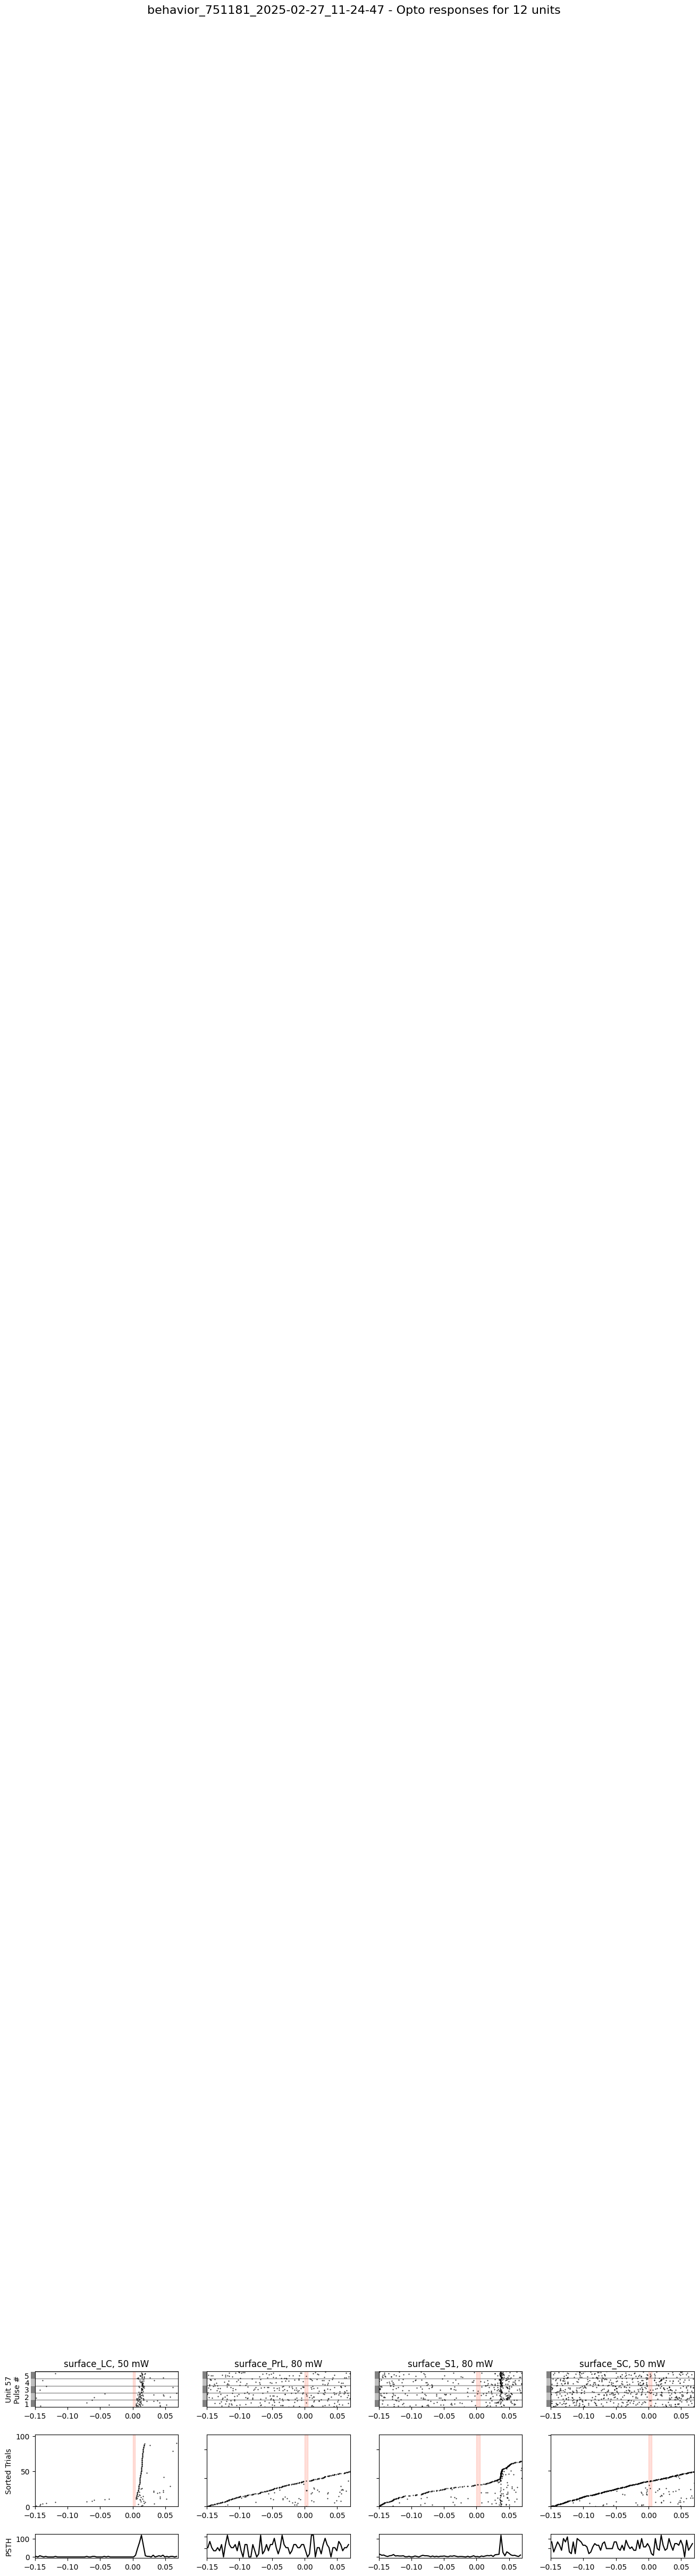

In [39]:
## Find antidromic unit without plotting
ROI_session = ['behavior_751181_2025-02-27_11-24-47']
for session in folders:
    if session in ROI_session:        
        if session in processed_session_id:
            print(f'{session} already processed')        
        else:
            subject_id = session.split('_')[1]
            print("subject id: ", subject_id)
            print("session: ", session)
            
            # load opto tagging data
            data_type = 'curated'
            target = 'soma'

            data_folder = f'{scratch_data_folder}/{subject_id}/{session}/ephys/opto/curated'
            print("Loading opto tagging data")

            try: 
                with open(os.path.join(data_folder, f'{session}_curated_soma_opto_tagging_summary.pkl'), 'rb') as f:            
                    unit_tbl = pickle.load(f)
            except Exception as e:
                print(f"Skipping {os.path.join(data_folder, f'{session}_curated_soma_opto_tagging_summary.pkl')} due to error: {e}")
                continue
            
            opto_units = unit_tbl.query("opto_pass == True & default_qc == True")["unit_id"].to_list()
            print("opto_units: ", opto_units)
            ## Load spike times

            print("Loading spiketimes")
            # session_dir = session_dirs(session)
            data_type = 'curated'

            try:
                with open(os.path.join(f'{scratch_data_folder}/{subject_id}/{session}/ephys/curated/processed', 'spiketimes.pkl'), 'rb') as f:
                    spiketimes = pickle.load(f)
            except Exception as e:
                print(f"Skipping {os.path.join(data_folder, 'spiketimes.pkl')} due to error: {e}")
                continue

            start = np.min(np.array([np.min(spiketimes[unit]) for unit in spiketimes.keys()]))
            end = np.max(np.array([np.max(spiketimes[unit]) for unit in spiketimes.keys()]))
            # Load opto event data
            opto_event_file = Path(f'{data_folder}/{session}_opto_session.csv')
            event_ids = pd.read_csv(opto_event_file)

            # Unique values
            sites = list(np.unique(event_ids.emission_location))
            powers = list(np.unique(event_ids.power))
            trial_types = np.unique(event_ids.type)

            opto_units = opto_units  # Limit to first 2 units for demonstration
            # Settings
            prepost = 'post'
            num_sites = len(sites)
            num_units = len(opto_units)

            # Create one figure for all units × sites (3 rows per unit: raster + PSTH + antidromic raster)
            fig_height_per_unit = 6
            fig = plt.figure(figsize=(num_sites * 4, num_units * fig_height_per_unit))
            fig.suptitle(f'{session} - Opto responses for {num_units} units', fontsize=16)
            gs = gridspec.GridSpec(4 * num_units, num_sites, height_ratios=[3, 6, 2, 0.5] * num_units, hspace=0.8)

            # Loop through units
            for u_idx, unit_id in enumerate(opto_units):
                if unit_id == 57:
                    unit_spike_times = spiketimes[unit_id]

                    for i, site in enumerate(sites):
                        # Filter trials
                        tag_trials = event_ids.query('site == @site and pre_post == @prepost')
                        max_power = tag_trials.power.max()
                        tag_trials = tag_trials.query('power == @max_power')
                        if tag_trials.empty:
                            continue

                        # Stimulation parameters
                        duration = np.unique(tag_trials.duration)[0]
                        num_pulses = np.unique(tag_trials.num_pulses)[0]
                        pulse_interval = np.unique(tag_trials.pulse_interval)[0]

                        # Time window
                        time_range_raster = np.array([-150 / 1000, 70 / 1000])
                        this_event_timestamps = tag_trials.time.tolist()

                        int_event_locked_timestamps = []
                        pulse_nums = []

                        for pulse_num in range(num_pulses):
                            time_shift = pulse_num * (duration + pulse_interval) / 1000
                            this_time_range = time_range_raster + time_shift

                            this_locked = af.event_locked_timestamps(
                                unit_spike_times, this_event_timestamps, this_time_range, time_shift=time_shift
                            )
                            int_event_locked_timestamps.extend(this_locked)
                            pulse_nums.extend([pulse_num + 1] * len(this_locked))

                        # Raster plot
                        ax_raster = fig.add_subplot(gs[4 * u_idx, i])
                        pf.raster_plot(int_event_locked_timestamps, time_range_raster, cond_each_trial=pulse_nums, ms=100, ax=ax_raster)

                        # Add laser pulse patch
                        yLims = np.array(ax_raster.get_ylim())
                        laser_color = 'tomato'
                        rect = patches.Rectangle((0, yLims[0]), duration / 1000, yLims[1] - yLims[0],
                                                linewidth=1, edgecolor=laser_color, facecolor=laser_color,
                                                alpha=0.2, clip_on=True)
                        ax_raster.add_patch(rect)

                        # Raster axis settings
                        if i == 0:
                            ax_raster.set_ylabel(f'Unit {unit_id}\nPulse #')
                        else:
                            ax_raster.set_yticklabels([])

                        ax_raster.set_xlim(time_range_raster)
                        if u_idx == num_units - 1:
                            ax_raster.set_xlabel('Time (s)')
                        ax_raster.set_title(f'{site}, {max_power} mW')


                        # Add laser pulse aligned but sorted by spike times
                        # Antidromic raster plot
                        ax_antidromic = fig.add_subplot(gs[4 * u_idx + 1, i], sharex=ax_raster)
                        sorted_data = sorted(int_event_locked_timestamps, key=lambda x: (len(x) == 0, x[0] if len(x) > 0 else np.inf))
                        if i==2:
                            ROI_sorted_data = sorted_data 

                        pf.raster_plot(sorted_data, time_range_raster)
                        # pf.raster_plot(sorted_data, time_range_raster, ax=ax_antidromic)

                        yLims = np.array(ax_antidromic.get_ylim())
                        rect = patches.Rectangle((0, yLims[0]), duration / 1000, yLims[1] - yLims[0],
                                                linewidth=1, edgecolor='tomato', facecolor='tomato',
                                                alpha=0.2, clip_on=False)
                        ax_antidromic.add_patch(rect)

                        ax_antidromic.set_xlim(time_range_raster)
                        if u_idx == num_units - 1:
                            ax_antidromic.set_xlabel('Time (s)')

                        if i == 0:
                            ax_antidromic.set_ylabel('Sorted Trials')
                        else:
                            ax_antidromic.set_yticklabels([])

                        # PSTH plot
                        ax_psth = fig.add_subplot(gs[4 * u_idx + 2, i], sharex=ax_raster)
                        psth, _, bins = pf.psth(int_event_locked_timestamps, time_range_raster, bin_size=0.003, smooth_window_size=3)
                        ax_psth.plot(bins, psth, color='k')
                        if i == 0:
                            ax_psth.set_ylabel('PSTH')
                        else:
                            ax_psth.set_yticklabels([])
                        ax_psth.set_xlim(time_range_raster)
                        if u_idx == num_units - 1:
                            ax_psth.set_xlabel('Time (s)')                                              


[np.float64(0.037517334893345855), np.float64(0.03692337460815909), np.float64(0.05004846155643461), np.float64(0.0349579291418195), np.float64(0.045350338518619526), np.float64(0.04541274011135099), np.float64(0.037663649581372693), np.float64(0.03687275089323516), np.float64(0.03809278160333629), np.float64(0.02308240532875061), np.float64(0.0298233013600111), np.float64(0.007740930467843965), np.float64(0.03657432999461885), np.float64(0.058448967151343845), np.float64(0.017157285101711772), np.float64(0.03889485877007248), np.float64(0.037072558701038316), np.float64(0.03632160015404223), np.float64(0.03696695640683173), np.float64(0.036686630547046684), np.float64(0.027968157641589664), np.float64(0.04969017133116721), np.float64(0.03547311592847108), np.float64(0.06171470135450363), np.float64(0.04762891046702861), np.float64(0.03224385473877189), np.float64(0.036107420548796676), np.float64(0.04705032259225844), np.float64(0.036745362170040596), np.float64(0.04093164838850494), 

(-0.05, 1.05)

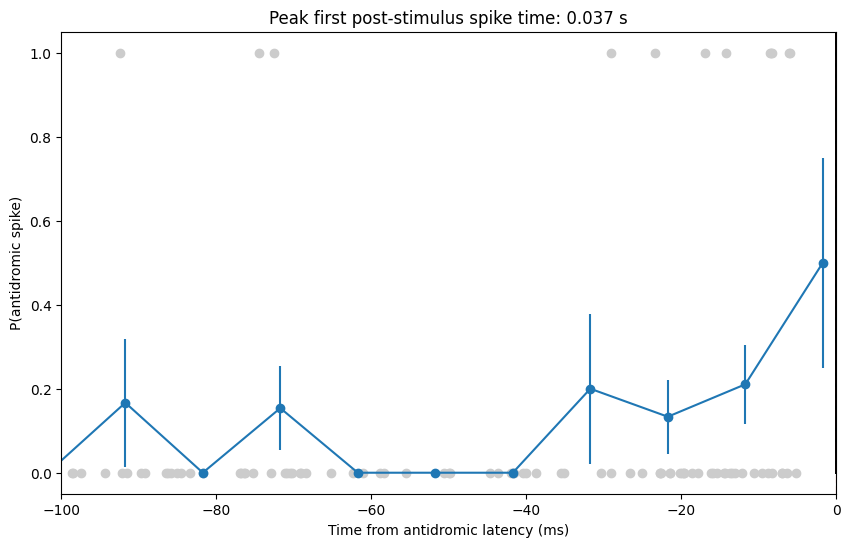

In [42]:
# antidromic analysis
# ROI_sorted_data = sorted_data 
first_post_stim_spike_times = []
all_spike_times = np.concatenate(ROI_sorted_data)

# sorted_data
for a, spike_times in enumerate(ROI_sorted_data):
    if spike_times.size > 0 and any(spike_times[spike_times > 0]):       
        first_post_stim_spike_times.append(spike_times[spike_times > 0][0])

print(first_post_stim_spike_times)
hist, bin_edges = np.histogram(first_post_stim_spike_times, bins=100)
# plot histogram
plt.figure(figsize=(10, 6))
plt.plot(bin_edges[:-1], hist, color='k')
plt.xlabel('First post-stimulus spike time (s)')
plt.ylabel('Count')
# find x-value for the peak 
peak_x = bin_edges[np.argmax(hist)]
antidromic_latency = peak_x
plt.axvline(peak_x, color='r', linestyle='--')
plt.title(f'Peak first post-stimulus spike time: {peak_x:.3f} s') 

print('antidromic latency:', peak_x)


import numpy as np
import pandas as pd

def Avg_y_over_x(x, y, bin_size):
    """
    Compute the average and standard error of y values binned by x.

    Parameters:
    x (array-like): The independent variable values.
    y (array-like): The dependent variable values.
    bin_size (float): The size of the bins for grouping x values.

    Returns:
    pd.DataFrame: A DataFrame with columns for bin centers (x), average y values (y), and standard error of the mean (sem).
    """
    # Calculate bin edges based on the bin size
    edges = np.arange(np.min(x), np.max(x) + bin_size, bin_size)
    
    # Digitize x into bins
    x_index = np.digitize(x, edges) - 1  # Bin indices for each x value
    
    # Calculate bin centers
    bin_centers = (edges[:-1] + edges[1:]) / 2
    
    # Create a DataFrame to store results
    Avg = pd.DataFrame({'x': bin_centers, 'y': np.nan, 'sem': np.nan})

    # Compute mean and standard error for each bin
    for i in range(len(bin_centers)):
        # Mask y values corresponding to the current bin
        bin_y_values = y[x_index == i]
        if bin_y_values.size > 0:
            Avg.at[i, 'y'] = np.nanmean(bin_y_values)
            Avg.at[i, 'sem'] = np.nanstd(bin_y_values) / np.sqrt(bin_y_values.size)

    return Avg, edges

all_spike_times = np.concatenate(ROI_sorted_data)
# Initialize variables

data = []
antidromic_jitter = 0.005

trial_num = 0
for a, spike_times in enumerate(ROI_sorted_data):
    if spike_times.size > 0:
        last_orthodromic_spike_time = []
        # Find orthodromic and antidromic spike times
        orthodromic_spike_times = spike_times[spike_times<=antidromic_latency-antidromic_jitter]        
        antidromic_spike_times = spike_times[(antidromic_latency - antidromic_jitter < spike_times) & (spike_times < antidromic_latency + antidromic_jitter)]
        
        # Collision determination
        if orthodromic_spike_times.size > 0:
            last_orthodromic_spike_time = orthodromic_spike_times[-1]
            if antidromic_spike_times.size > 0:
                collision = 0
            else:
                collision = 1
        else:    
            last_orthodromic_spike_time = None
    # Append trial data to list
    data.append({
        'trial_num': trial_num,
        'spike_times': spike_times.tolist(),  # Convert arrays to lists
        'ortho_spike_times': orthodromic_spike_times.tolist(),  # Convert arrays to lists
        'last_orthodromic_spike_time': last_orthodromic_spike_time,
        'anti_spike_times': antidromic_spike_times.tolist(),  # Convert arrays to lists
        'collision': collision
    })
    trial_num += 1

# Create DataFrame from collected data
antidromic_df = pd.DataFrame(data)     
    
    # Display the DataFrame
antidromic_df
roi_df = antidromic_df.query('last_orthodromic_spike_time.notnull()')
roi_df['last_orthodromic_spike_time']
x = (roi_df['last_orthodromic_spike_time'] - antidromic_latency)*1000
y = 1-roi_df['collision']
plt.plot(x, y, 'o', label='Antidromic spikes', color = [0.8, 0.8, 0.8])
# edges = np.arange(-0.1, 0.1, 0.01)
result, edges = Avg_y_over_x(x, y, bin_size = 10)
plt.errorbar(result['x'], result['y'], yerr=result['sem'], fmt='o-', label='Average y with SEM')
plt.xlabel('Time from antidromic latency (ms)')
plt.ylabel('P(antidromic spike)')
print(edges)
plt.xlim([-100, 0])
plt.ylim([-0.05, 1.05])



# # test whether the peak is significantly different from shuppled spike times
# # generate shuffled data
# shuffled_data = []
# for _ in range(1000):
#     shuffled_spike_times = np.random.choice(first_post_stim_spike_times, size=len(first_post_stim_spike_times), replace=True)
#     shuffled_data.append(shuffled_spike_times)
# # calculate histogram for shuffled data
# shuffled_hist, shuffled_bin_edges = np.histogram(shuffled_data, bins=100)
# # plot histogram
# plt.figure(figsize=(10, 6))
# plt.plot(shuffled_bin_edges[:-1], shuffled_hist, color='k')
# plt.xlabel('First post-stimulus spike time (s)')
# plt.ylabel('Count')
# # find x-value for the peak
# peak_x = shuffled_bin_edges[np.argmax(shuffled_hist)]
# plt.axvline(peak_x, color='r', linestyle='--')
# plt.title(f'Peak first post-stimulus spike time: {peak_x:.3f} s')



    



        

[np.float64(0.037517334893345855), np.float64(0.03692337460815909), np.float64(0.05004846155643461), np.float64(0.0349579291418195), np.float64(0.045350338518619526), np.float64(0.04541274011135099), np.float64(0.037663649581372693), np.float64(0.03687275089323516), np.float64(0.03809278160333629), np.float64(0.02308240532875061), np.float64(0.0298233013600111), np.float64(0.007740930467843965), np.float64(0.03657432999461885), np.float64(0.058448967151343845), np.float64(0.017157285101711772), np.float64(0.03889485877007248), np.float64(0.037072558701038316), np.float64(0.03632160015404223), np.float64(0.03696695640683173), np.float64(0.036686630547046684), np.float64(0.027968157641589664), np.float64(0.04969017133116721), np.float64(0.03547311592847108), np.float64(0.06171470135450363), np.float64(0.04762891046702861), np.float64(0.03224385473877189), np.float64(0.036107420548796676), np.float64(0.04705032259225844), np.float64(0.036745362170040596), np.float64(0.04093164838850494), 

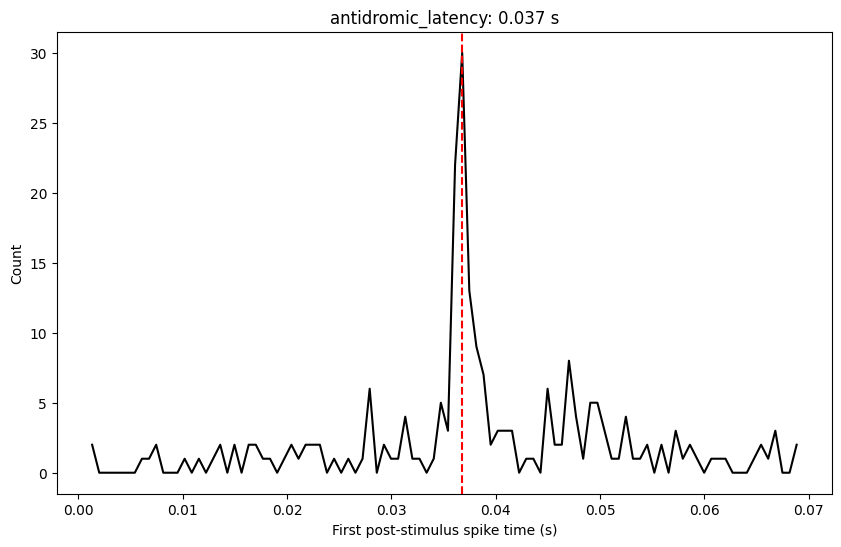

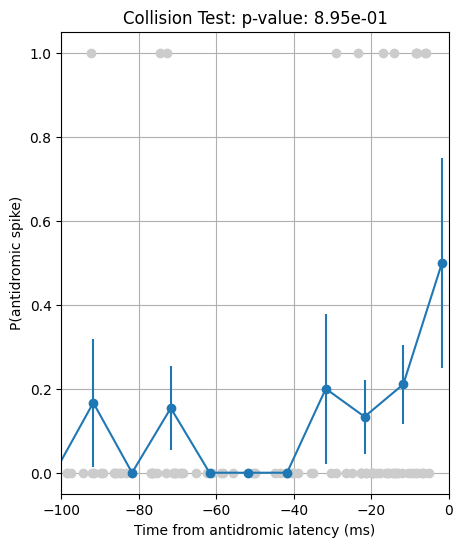

Mann-Whitney U test statistic: 1494.0000
P-value: 1.1482e-10
P(antidromic spike) is significantly lower near antidromic latency (p < 0.05).


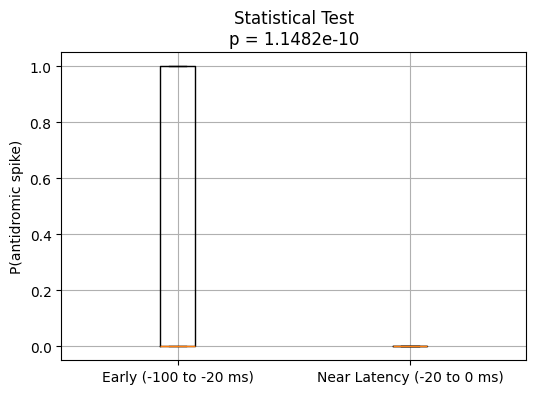

In [ ]:
## No figure, code collision test
result_folder = '/scratch/antidromic'
# Load the session summary CSV file
session_summary_path = os.path.join(result_folder, 'session_summary.csv')
session_summary_df = pd.read_csv(session_summary_path)
from scipy.stats import wilcoxon

def opto_tagging_response(int_event_locked_timestamps, base_window, roi_window):
    base_counts = []
    roi_counts = []

    for spike_times in int_event_locked_timestamps:
        if spike_times.size > 0:
            base_count = np.sum((spike_times >= base_window[0]) & (spike_times < base_window[1]))
            roi_count = np.sum((spike_times >= roi_window[0]) & (spike_times < roi_window[1]))
            base_counts.append(base_count)
            roi_counts.append(roi_count)

    base_counts = np.array(base_counts)
    roi_counts = np.array(roi_counts)

    # ✅ Only run test if we have at least 2 samples
    if len(base_counts) >= 2 and len(roi_counts) >= 2:
        try:
            stat, p_value = wilcoxon(base_counts, roi_counts)
            return p_value
        except ValueError:
            return np.nan
    else:
        return np.nan

    
def plot_opto_responses(unit_tbl, event_ids, spiketimes, session_id):
    results = []

    # Filter for opto tagged units
    opto_criteria = (unit_tbl['opto_pass'] == True) & (unit_tbl['default_qc'] == True)
    opto_units = unit_tbl[opto_criteria]["unit_id"].to_list()
    print(f"Session {session_id}: {len(opto_units)} opto-tagged units")

    
    # Unique values
    sites = list(np.unique(event_ids.emission_location))
    powers = list(np.unique(event_ids.power))
    trial_types = np.unique(event_ids.type)
    
    # Settings
    prepost = 'post'
    num_sites = len(sites)
    num_units = len(opto_units)

   
    # Loop through units
    for u_idx, unit_id in enumerate(opto_units):
        # if unit_id == 244:
        unit_spike_times = spiketimes[unit_id]

        for i, site in enumerate(sites):
            base_window = (-0.02, 0)
            roi_window = (0, 0.02) if site == 'surface_LC' else (0.03, 0.05)


            # Filter trials
            tag_trials = event_ids.query('site == @site and pre_post == @prepost')
            max_power = tag_trials.power.max()
            tag_trials = tag_trials.query('power == @max_power')
            if tag_trials.empty:
                continue

            # Stimulation parameters
            duration = np.unique(tag_trials.duration)[0]
            num_pulses = np.unique(tag_trials.num_pulses)[0]
            pulse_interval = np.unique(tag_trials.pulse_interval)[0]

            # Time window
            time_range_raster = np.array([-100 / 1000, 70 / 1000])
            this_event_timestamps = tag_trials.time.tolist()

            int_event_locked_timestamps = []
            pulse_nums = []

            for pulse_num in range(num_pulses):
                time_shift = pulse_num * (duration + pulse_interval) / 1000
                this_time_range = time_range_raster + time_shift

                this_locked = af.event_locked_timestamps(
                    unit_spike_times, this_event_timestamps, this_time_range, time_shift=time_shift
                )
                int_event_locked_timestamps.extend(this_locked)
                pulse_nums.extend([pulse_num + 1] * len(this_locked))

            # Perform significance test
            if len(int_event_locked_timestamps) != 0:
                p_val = opto_tagging_response(int_event_locked_timestamps, base_window, roi_window)
            if not np.isnan(p_val):
                results.append({
                    'unit_id': unit_id,
                    'site': site,
                    'p_value': round(p_val, 3)
                })
    return results



# ---- Main loop: compute opto response stats ----
all_opto_stats = []
session_summary_df['opto_units'] = None


for index, row in session_summary_df.iterrows():
    session = row['session']
    session_id = row['session_id']
    session_path = row['session_path']
    summary_file_path = row['summary_file_path']
    summary_exists = row['summary_exists']
    opto_session_file_path = row['opto_session_file_path'] 
    opto_session_exists = row['opto_session_exists']               
    spiketimes_file_path = row['spiketimes_file_path']
    spiketimes_exists = row['spiketimes_exists']

    if summary_exists and opto_session_exists and spiketimes_exists:
        print(f"Processing session: {session}")
        # Load the summary file
        unit_tbl = pd.read_pickle(summary_file_path)
        # print(f"Loaded summary file for {session}")
        # Load the opto session file
        event_ids = pd.read_csv(opto_session_file_path)
        # print(f"Loaded opto session file for {session}")
        # Load the spiketimes file
        with open(spiketimes_file_path, 'rb') as f:
            spiketimes = pickle.load(f)        

        # Filter for opto tagged units
        opto_criteria = (unit_tbl['opto_pass'] == True) & (unit_tbl['default_qc'] == True)
        opto_units = unit_tbl[opto_criteria]["unit_id"].to_list()
        # add opto_units to session_summary_df
        session_summary_df.at[index, 'opto_units'] = opto_units

        # Collect per-session result
        opto_stats = plot_opto_responses(unit_tbl, event_ids, spiketimes, session_id)
        all_opto_stats.append(opto_stats)
    else:
        all_opto_stats.append([])  # For missing files, add empty list

# Add full stats to DataFrame
session_summary_df['opto_unit_stats'] = all_opto_stats

from collections import defaultdict

# First, get all unique site names across all sessions
all_sites = set()
for stats in all_opto_stats:
    for entry in stats:
        all_sites.add(entry['site'])

# Initialize new columns in the DataFrame
for site in all_sites:
    col_name = f"sig_units_{site}"
    session_summary_df[col_name] = [[] for _ in range(len(session_summary_df))]

# Populate those columns with unit_ids that have p < 0.05
for i, stats in enumerate(session_summary_df['opto_unit_stats']):
    site_to_units = defaultdict(list)
    for entry in stats:
        if entry['p_value'] < 0.05:
            site_to_units[entry['site']].append(entry['unit_id'])

    # Assign to columns
    for site in all_sites:
        col_name = f"sig_units_{site}"
        session_summary_df.at[i, col_name] = site_to_units.get(site, [])

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Assume you already have these ---
# all_spike_times = np.concatenate(ROI_sorted_data)
# antidromic_latency (scalar, in seconds)
# antidromic_jitter = 0.005

# Step 1: Preprocessing
num_trials = len(ROI_sorted_data)
last_ortho_spike_times = np.full(num_trials, np.nan)
collision_flags = np.ones(num_trials, dtype=int)  # Start assuming collision (=1), change later if antidromic spike exists

# antidromic analysis
# ROI_sorted_data = sorted_data 
first_post_stim_spike_times = []
all_spike_times = np.concatenate(ROI_sorted_data)

# sorted_data
for a, spike_times in enumerate(ROI_sorted_data):
    if spike_times.size > 0 and any(spike_times[spike_times > 0]):       
        first_post_stim_spike_times.append(spike_times[spike_times > 0][0])

print(first_post_stim_spike_times)
hist, bin_edges = np.histogram(first_post_stim_spike_times, bins=100)
# plot histogram
plt.figure(figsize=(10, 6))
plt.plot(bin_edges[:-1], hist, color='k')
plt.xlabel('First post-stimulus spike time (s)')
plt.ylabel('Count')
# find x-value for the peak 
peak_x = bin_edges[np.argmax(hist)]
antidromic_latency = peak_x
plt.axvline(peak_x, color='r', linestyle='--')
plt.title(f'antidromic_latency: {peak_x:.3f} s') 

# Step 2: Vectorized processing
for i, spike_times in enumerate(ROI_sorted_data):
    if spike_times.size == 0:
        continue
    
    ortho_mask = spike_times <= (antidromic_latency - antidromic_jitter)
    anti_mask = (antidromic_latency - antidromic_jitter < spike_times) & (spike_times < antidromic_latency + antidromic_jitter)
    
    ortho_spikes = spike_times[ortho_mask]
    anti_spikes = spike_times[anti_mask]
    
    if ortho_spikes.size > 0:
        last_ortho_spike_times[i] = ortho_spikes[-1]  # Only keep the last orthodromic spike
    
    if anti_spikes.size > 0:
        collision_flags[i] = 0  # If antidromic spike exists, collision = 0 (no collision)

# Step 3: Assemble DataFrame
antidromic_df = pd.DataFrame({
    'trial_num': np.arange(num_trials),
    'last_orthodromic_spike_time': last_ortho_spike_times,
    'collision': collision_flags
})

# Step 4: ROI selection and plot
roi_df = antidromic_df.dropna(subset=['last_orthodromic_spike_time'])  # Keep only trials with orthodromic spikes

x = (roi_df['last_orthodromic_spike_time'].values - antidromic_latency) * 1000  # in ms
y = 1 - roi_df['collision'].values  # 1 = successful antidromic spike, 0 = collision

from scipy.stats import mannwhitneyu
# Define windows (you can adjust these)
early_window = (-100, -70)  # in ms
near_latency_window = (-30, 0)

# Select data in each window
early_indices = (x >= early_window[0]) & (x < early_window[1])
near_latency_indices = (x >= near_latency_window[0]) & (x <= near_latency_window[1])

early_probs = y[early_indices]
near_latency_probs = y[near_latency_indices]

# Perform Mann-Whitney U test
statistic, p_value = mannwhitneyu(early_probs, near_latency_probs, alternative='greater')

print(f"Mann-Whitney U test statistic: {statistic:.4f}")


# Interpretation
if p_value < 0.05:
    print("P(antidromic spike) is significantly lower near antidromic latency (p < 0.05).")
else:
    print("No significant decrease in P(antidromic spike) near antidromic latency.")

# Scatter plot
plt.figure(figsize=(5, 6))
plt.plot(x, y, 'o', color=[0.8, 0.8, 0.8], label='Antidromic spikes')

# Bin averages
def Avg_y_over_x(x, y, bin_size):
    edges = np.arange(np.min(x), np.max(x) + bin_size, bin_size)
    x_idx = np.digitize(x, edges) - 1
    bin_centers = (edges[:-1] + edges[1:]) / 2
    avg_y = np.full_like(bin_centers, np.nan, dtype=np.float64)
    sem_y = np.full_like(bin_centers, np.nan, dtype=np.float64)
    
    for i in range(len(bin_centers)):
        bin_y = y[x_idx == i]
        if bin_y.size > 0:
            avg_y[i] = np.nanmean(bin_y)
            sem_y[i] = np.nanstd(bin_y) / np.sqrt(bin_y.size)
    
    avg_df = pd.DataFrame({'x': bin_centers, 'y': avg_y, 'sem': sem_y})
    return avg_df, edges

# Plot binned averages
result, edges = Avg_y_over_x(x, y, bin_size=10)
plt.errorbar(result['x'], result['y'], yerr=result['sem'], fmt='o-', label='Average ± SEM')
plt.xlabel('Time from antidromic latency (ms)')
plt.ylabel('P(antidromic spike)')
plt.title(f'Collision Test: p-value: {p_value:.2e}')  # <- use f-string
plt.xlim([-100, 0])
plt.ylim([-0.05, 1.05])
# plt.legend()
plt.grid(True)
plt.show()

# print('Bin edges:', edges)

# plt.figure(figsize=(6, 4))
# plt.boxplot([early_probs, near_latency_probs], labels=['Early (-100 to -70 ms)', 'Near Latency (-30 to 0 ms)'])
# plt.ylabel('P(antidromic spike)')
# plt.title(f'Statistical Test\np = {p_value:.4e}')
# plt.grid(True)
# plt.show()


In [ ]:
## Old antidromic analysis
ROI_session = ['behavior_751181_2025-02-27_11-24-47']
for session in folders:
    if session in ROI_session:        
        if session in processed_session_id:
            print(f'{session} already processed')        
        else:
            subject_id = session.split('_')[1]
            print("subject id: ", subject_id)
            print("session: ", session)
            # session_dir = session_dirs(session)
                        
            # load opto tagging data
            data_type = 'curated'
            target = 'soma'


            data_folder = f'{scratch_data_folder}/{subject_id}/{session}/ephys/opto/curated'
            print("Loading opto tagging data")

            try: 
                with open(os.path.join(data_folder, f'{session}_curated_soma_opto_tagging_summary.pkl'), 'rb') as f:            
                    unit_tbl = pickle.load(f)
            except Exception as e:
                print(f"Skipping {os.path.join(data_folder, f'{session}_curated_soma_opto_tagging_summary.pkl')} due to error: {e}")
                continue
            
            opto_units = unit_tbl.query("opto_pass == True & default_qc == True")["unit_id"].to_list()
            print("opto_units: ", opto_units)
            ## Load spike times

            print("Loading spiketimes")
            # session_dir = session_dirs(session)
            data_type = 'curated'

            try:
                with open(os.path.join(f'{scratch_data_folder}/{subject_id}/{session}/ephys/curated/processed', 'spiketimes.pkl'), 'rb') as f:
                    spiketimes = pickle.load(f)
            except Exception as e:
                print(f"Skipping {os.path.join(data_folder, 'spiketimes.pkl')} due to error: {e}")
                continue

            start = np.min(np.array([np.min(spiketimes[unit]) for unit in spiketimes.keys()]))
            end = np.max(np.array([np.max(spiketimes[unit]) for unit in spiketimes.keys()]))
            # Load opto event data
            opto_event_file = Path(f'{data_folder}/{session}_opto_session.csv')
            event_ids = pd.read_csv(opto_event_file)

            # Unique values
            sites = list(np.unique(event_ids.emission_location))
            powers = list(np.unique(event_ids.power))
            trial_types = np.unique(event_ids.type)

            opto_units = opto_units  # Limit to first 2 units for demonstration
            # Settings
            prepost = 'post'
            num_sites = len(sites)
            num_units = len(opto_units)

            # Create one figure for all units × sites (3 rows per unit: raster + PSTH + antidromic raster)
            fig_height_per_unit = 6
            fig = plt.figure(figsize=(num_sites * 4, num_units * fig_height_per_unit))
            fig.suptitle(f'{session} - Opto responses for {num_units} units', fontsize=16)
            gs = gridspec.GridSpec(4 * num_units, num_sites, height_ratios=[3, 6, 2, 0.5] * num_units, hspace=0.8)

            # Loop through units
            for u_idx, unit_id in enumerate(opto_units):
                if unit_id == 244:
                    unit_spike_times = spiketimes[unit_id]

                    for i, site in enumerate(sites):
                        # Filter trials
                        tag_trials = event_ids.query('site == @site and pre_post == @prepost')
                        max_power = tag_trials.power.max()
                        tag_trials = tag_trials.query('power == @max_power')
                        if tag_trials.empty:
                            continue

                        # Stimulation parameters
                        duration = np.unique(tag_trials.duration)[0]
                        num_pulses = np.unique(tag_trials.num_pulses)[0]
                        pulse_interval = np.unique(tag_trials.pulse_interval)[0]

                        # Time window
                        time_range_raster = np.array([-150 / 1000, 70 / 1000])
                        this_event_timestamps = tag_trials.time.tolist()

                        int_event_locked_timestamps = []
                        pulse_nums = []

                        for pulse_num in range(num_pulses):
                            time_shift = pulse_num * (duration + pulse_interval) / 1000
                            this_time_range = time_range_raster + time_shift

                            this_locked = af.event_locked_timestamps(
                                unit_spike_times, this_event_timestamps, this_time_range, time_shift=time_shift
                            )
                            int_event_locked_timestamps.extend(this_locked)
                            pulse_nums.extend([pulse_num + 1] * len(this_locked))

                        # Raster plot
                        ax_raster = fig.add_subplot(gs[4 * u_idx, i])
                        pf.raster_plot(int_event_locked_timestamps, time_range_raster, cond_each_trial=pulse_nums, ms=100, ax=ax_raster)

                        # Add laser pulse patch
                        yLims = np.array(ax_raster.get_ylim())
                        laser_color = 'tomato'
                        rect = patches.Rectangle((0, yLims[0]), duration / 1000, yLims[1] - yLims[0],
                                                linewidth=1, edgecolor=laser_color, facecolor=laser_color,
                                                alpha=0.2, clip_on=True)
                        ax_raster.add_patch(rect)

                        # Raster axis settings
                        if i == 0:
                            ax_raster.set_ylabel(f'Unit {unit_id}\nPulse #')
                        else:
                            ax_raster.set_yticklabels([])

                        ax_raster.set_xlim(time_range_raster)
                        if u_idx == num_units - 1:
                            ax_raster.set_xlabel('Time (s)')
                        ax_raster.set_title(f'{site}, {max_power} mW')


                        # Add laser pulse aligned but sorted by spike times
                        # Antidromic raster plot
                        ax_antidromic = fig.add_subplot(gs[4 * u_idx + 1, i], sharex=ax_raster)
                        sorted_data = sorted(int_event_locked_timestamps, key=lambda x: (len(x) == 0, x[0] if len(x) > 0 else np.inf))
                        if i == 2:
                            ROI_sorted_data = sorted_data
                        pf.raster_plot(sorted_data, time_range_raster)
                        # pf.raster_plot(sorted_data, time_range_raster, ax=ax_antidromic)

                        yLims = np.array(ax_antidromic.get_ylim())
                        rect = patches.Rectangle((0, yLims[0]), duration / 1000, yLims[1] - yLims[0],
                                                linewidth=1, edgecolor='tomato', facecolor='tomato',
                                                alpha=0.2, clip_on=False)
                        ax_antidromic.add_patch(rect)

                        ax_antidromic.set_xlim(time_range_raster)
                        if u_idx == num_units - 1:
                            ax_antidromic.set_xlabel('Time (s)')

                        if i == 0:
                            ax_antidromic.set_ylabel('Sorted Trials')
                        else:
                            ax_antidromic.set_yticklabels([])

                        # PSTH plot
                        ax_psth = fig.add_subplot(gs[4 * u_idx + 2, i], sharex=ax_raster)
                        psth, _, bins = pf.psth(int_event_locked_timestamps, time_range_raster, bin_size=0.003, smooth_window_size=3)
                        ax_psth.plot(bins, psth, color='k')
                        if i == 0:
                            ax_psth.set_ylabel('PSTH')
                        else:
                            ax_psth.set_yticklabels([])
                        ax_psth.set_xlim(time_range_raster)
                        if u_idx == num_units - 1:
                            ax_psth.set_xlabel('Time (s)')
                        

                        

            # Final layout adjustments
            # fig.tight_layout(rect=[0, 0.03, 1, 0.95])
        
            # # Save figure as pdf
            # fig.savefig(os.path.join(result_folder, f'{session}_antidromic_raster_summary.pdf'), bbox_inches='tight')   
            # print(f'Saved figure to {result_folder}/{session}_antidromic_raster_summary.pdf')     

behavior_716325_2024-05-31_10-31-14 already processed
behavior_717121_2024-06-15_10-00-58 already processed
behavior_751766_2025-02-13_11-31-21 already processed
behavior_751766_2025-02-11_11-53-38 already processed
behavior_751766_2025-02-14_11-37-11 already processed
behavior_751766_2025-02-15_12-08-11
Skipping /data/LC-NE_scratch_data/751766/behavior_751766_2025-02-15_12-08-11/ephys/opto/curated/behavior_751766_2025-02-15_12-08-11_curated_soma_opto_tagging_summary.pkl due to error: [Errno 2] No such file or directory: '/data/LC-NE_scratch_data/751766/behavior_751766_2025-02-15_12-08-11/ephys/opto/curated/behavior_751766_2025-02-15_12-08-11_curated_soma_opto_tagging_summary.pkl'
behavior_754897_2025-03-12_12-23-15 already processed
behavior_754897_2025-03-11_12-07-41 already processed
behavior_754897_2025-03-14_11-28-53 already processed
behavior_754897_2025-03-13_11-20-42 already processed
behavior_754897_2025-03-15_11-32-18
Skipping /data/LC-NE_scratch_data/754897/behavior_754897_2

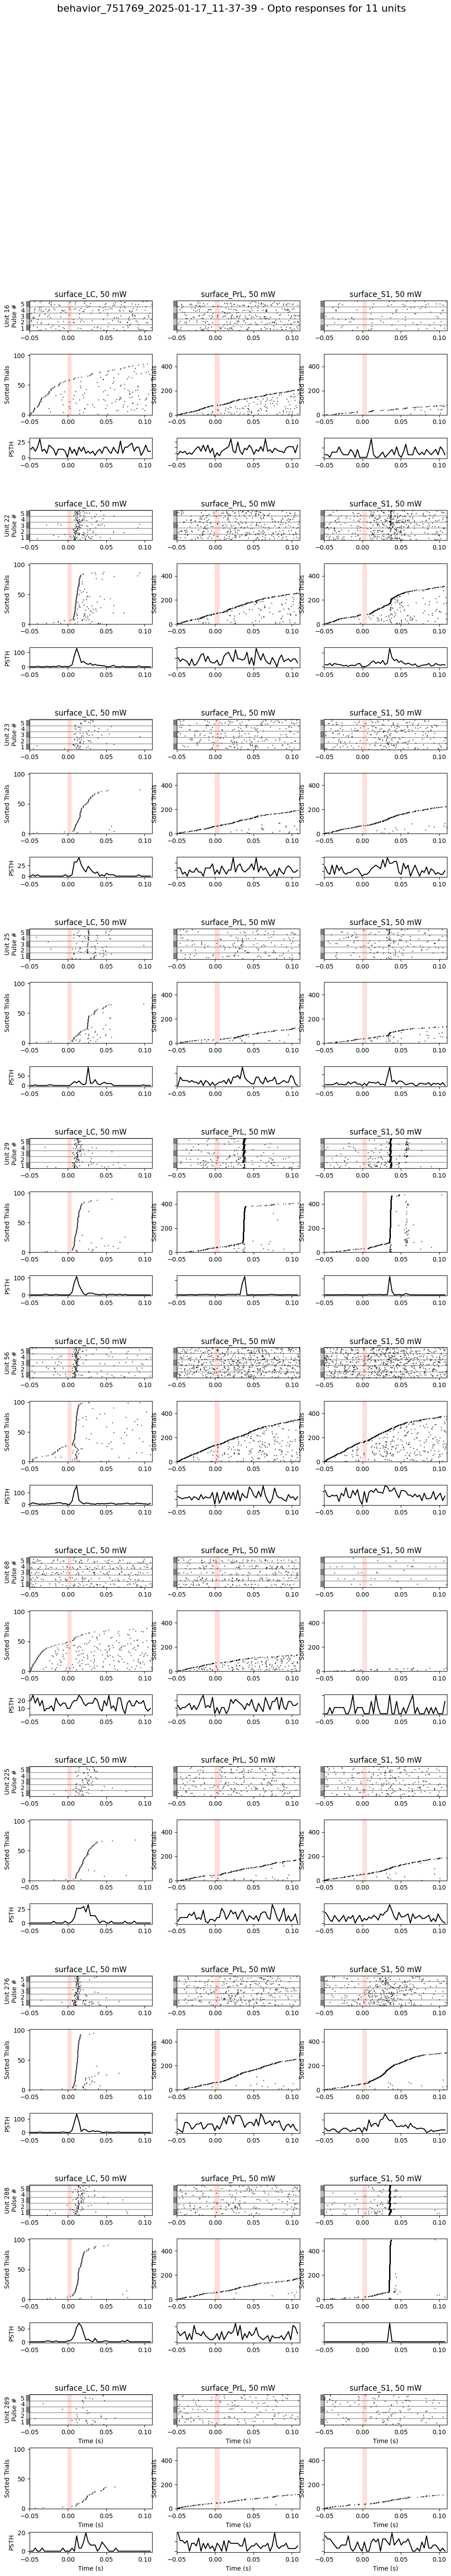

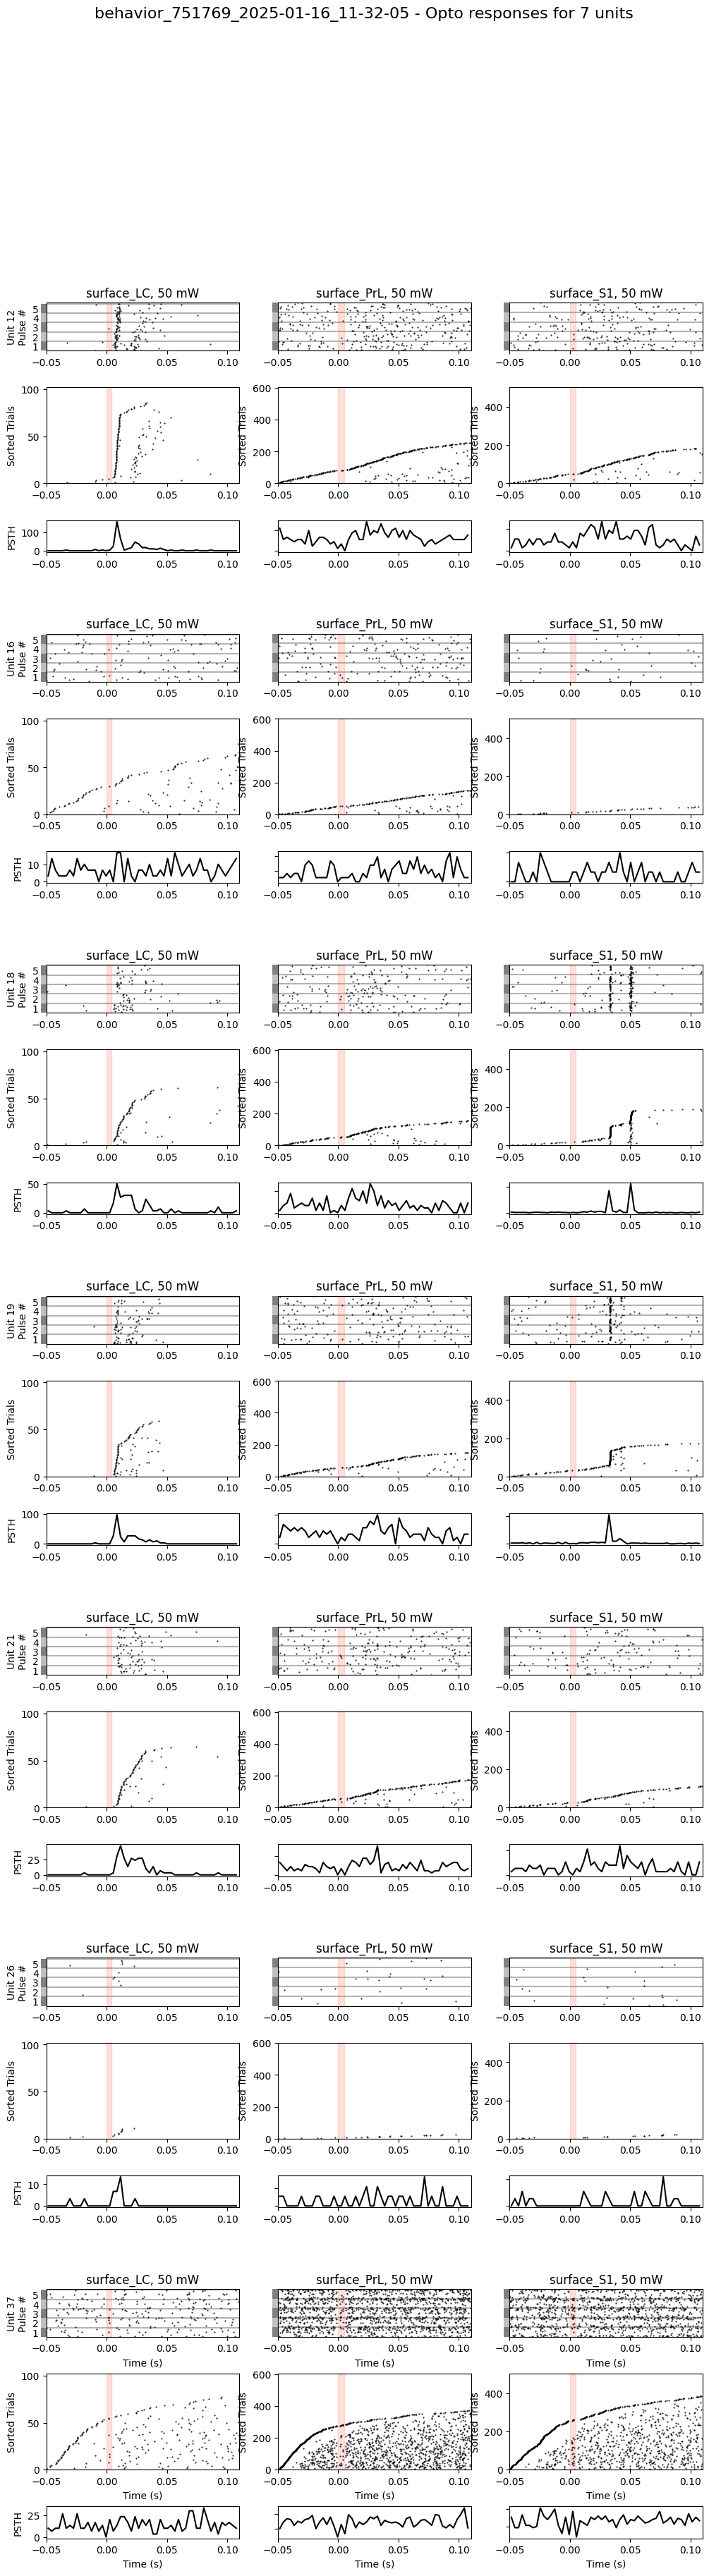

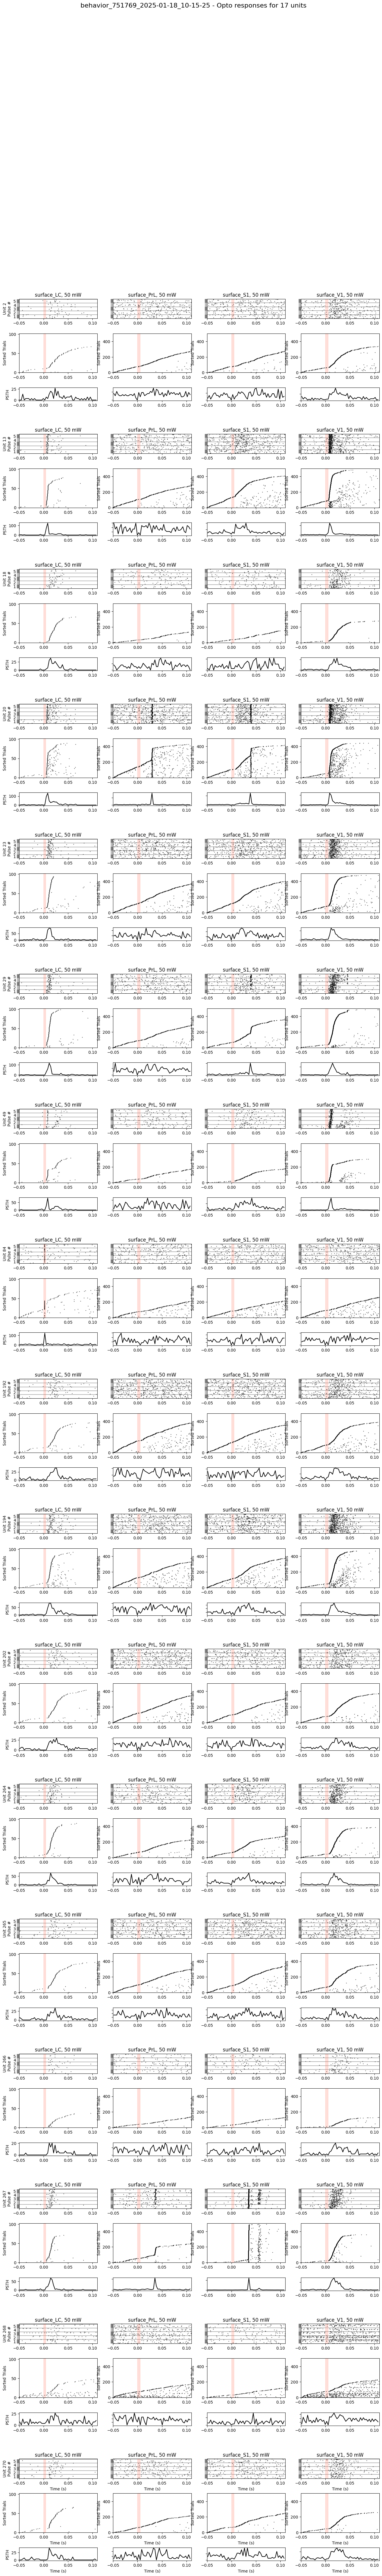

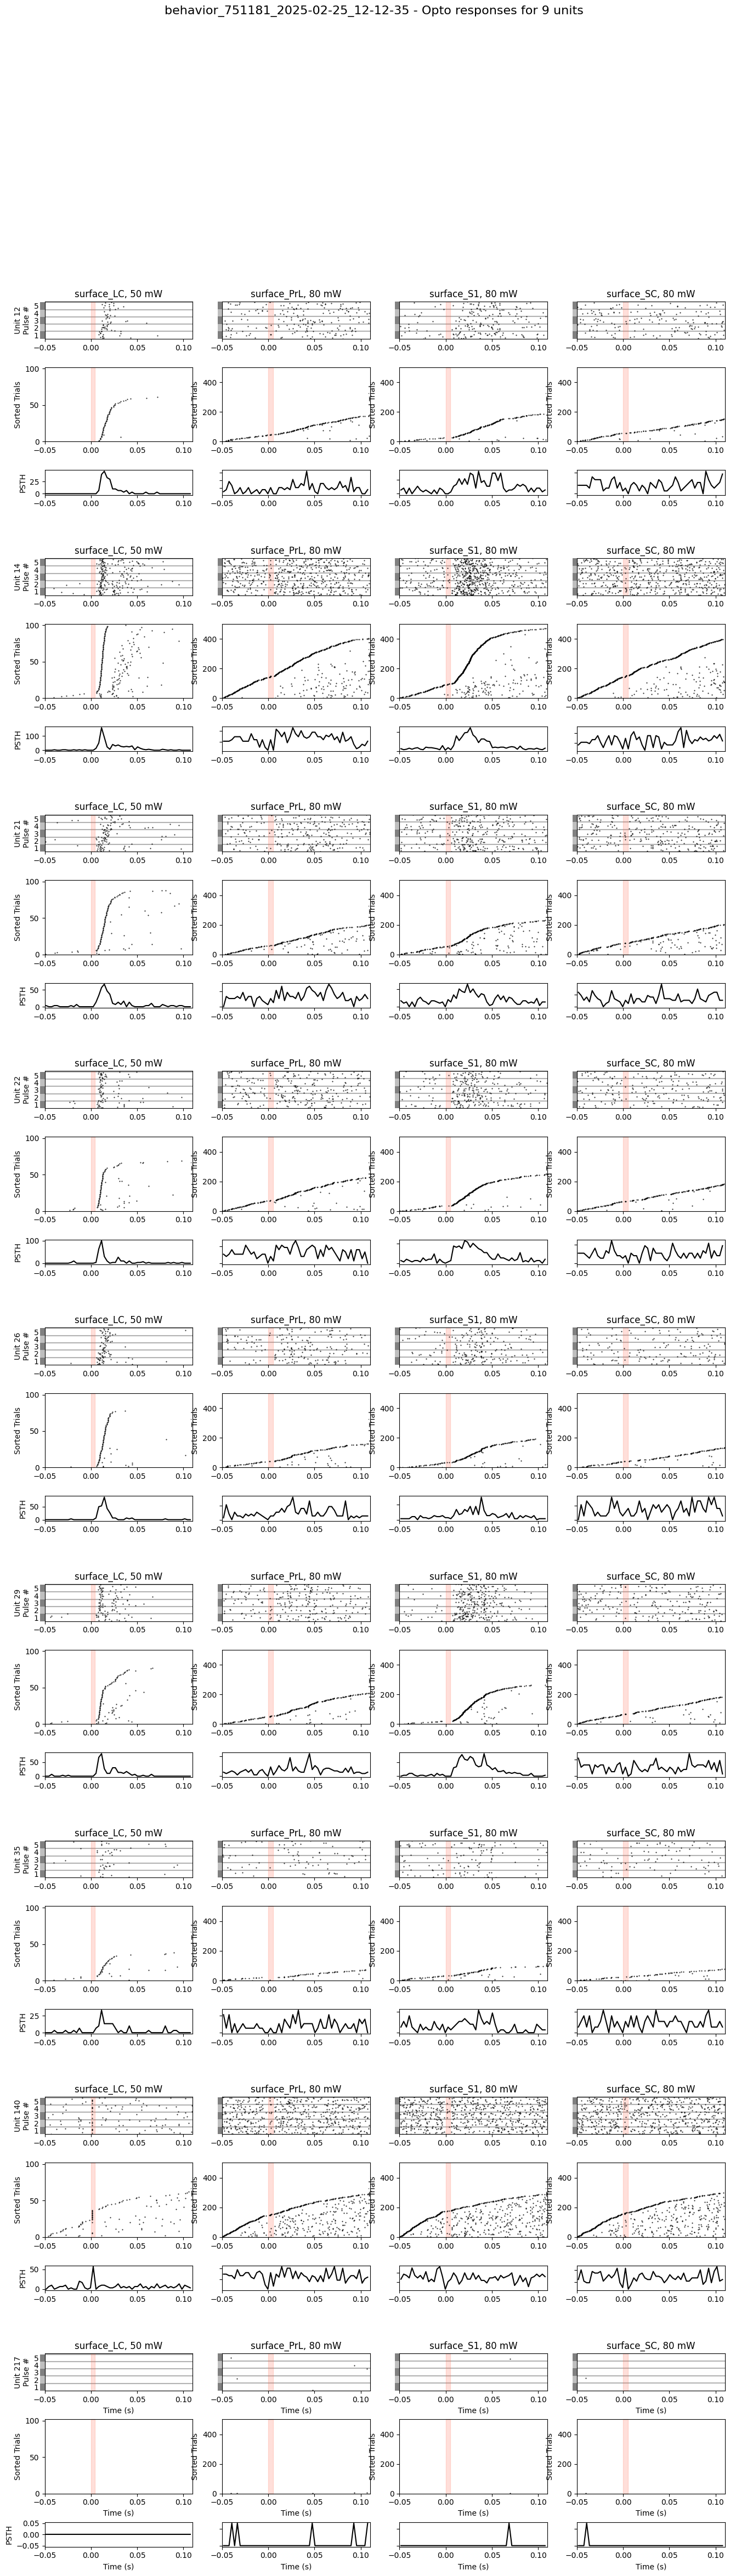

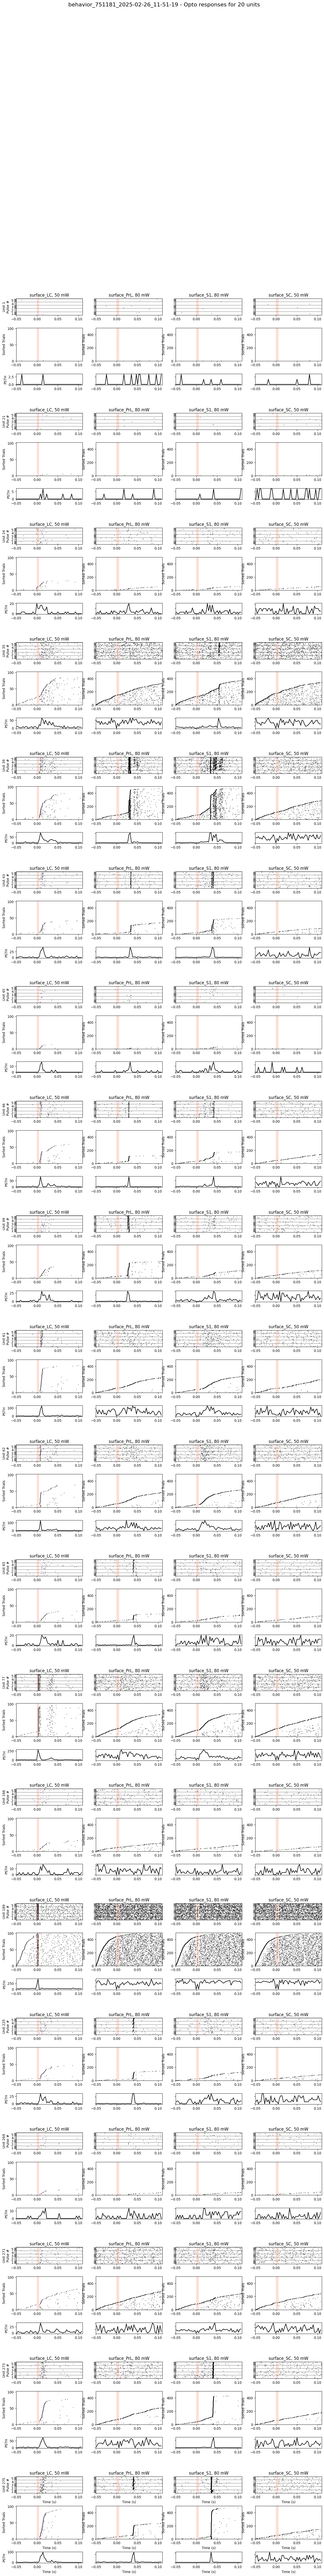

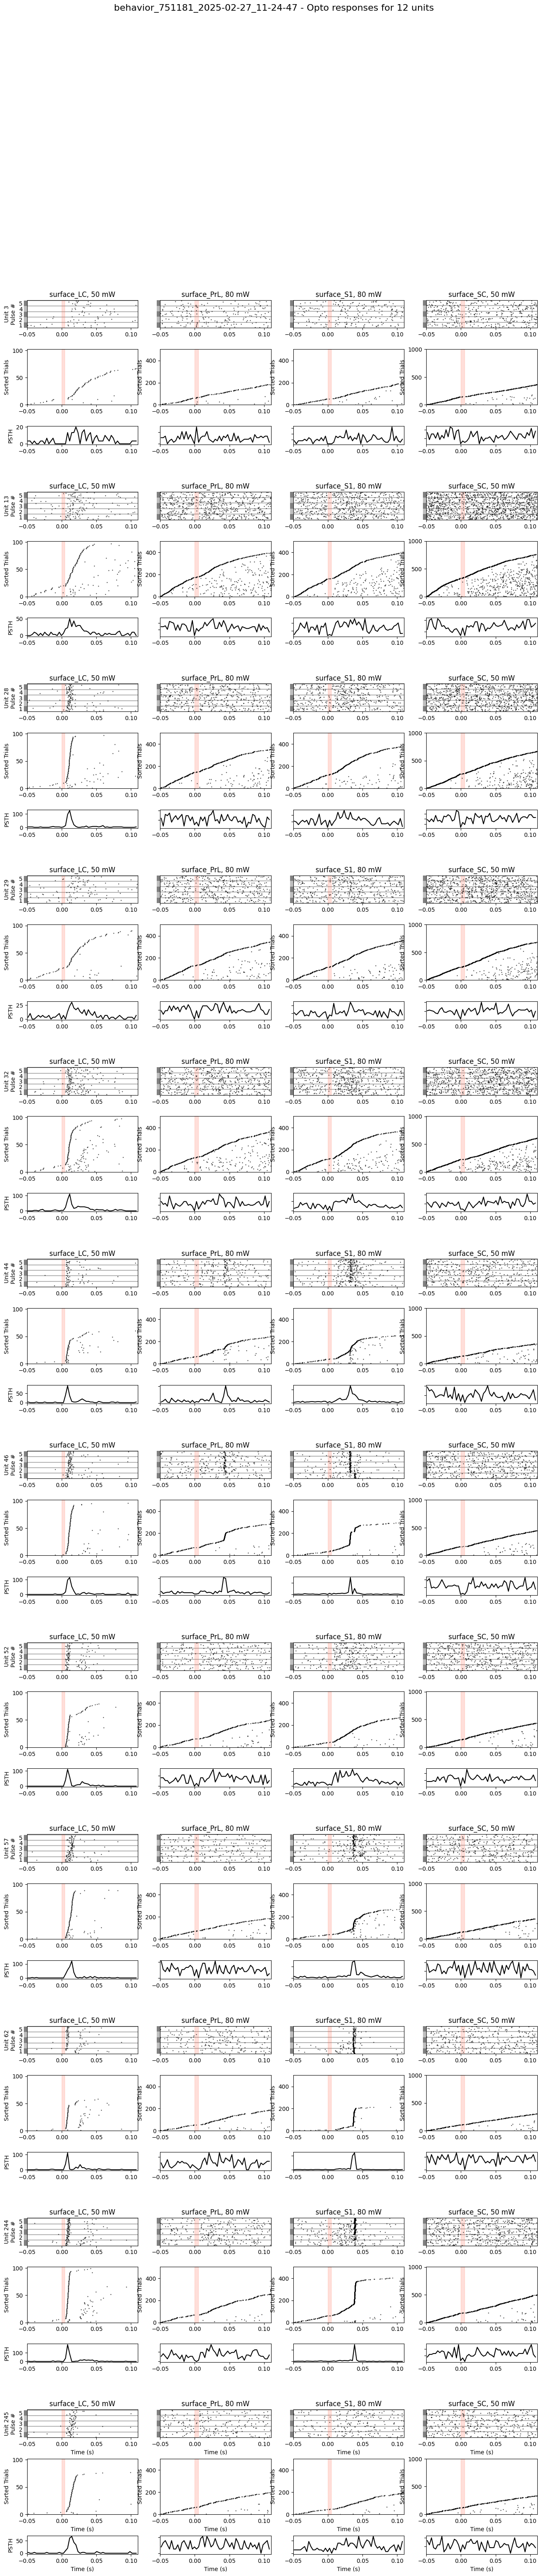

In [4]:
for session in folders:
    if session in processed_session_id:
        print(f'{session} already processed')        
    else:
        subject_id = session.split('_')[1]
        print(session)
        # session_dir = session_dirs(session)
        data_type = 'curated'
        target = 'soma'

        data_folder = f'/data/LC-NE_scratch_data/{subject_id}/{session}/ephys/opto/curated'
        # load opto tagging data
        try: 
            with open(os.path.join(data_folder, f'{session}_curated_soma_opto_tagging_summary.pkl'), 'rb') as f:            
                unit_tbl = pickle.load(f)
        except Exception as e:
            print(f"Skipping {os.path.join(data_folder, f'{session}_curated_soma_opto_tagging_summary.pkl')} due to error: {e}")
            continue
        opto_units = unit_tbl.query("opto_pass == True & default_qc == True")["unit_id"].to_list()
        print(opto_units)
        ## Load spike times
        # session_dir = session_dirs(session)
        data_type = 'curated'

        try:
            with open(os.path.join(f'/data/LC-NE_scratch_data/{subject_id}/{session}/ephys/curated/processed', 'spiketimes.pkl'), 'rb') as f:
                spiketimes = pickle.load(f)
        except Exception as e:
            print(f"Skipping {os.path.join(data_folder, 'spiketimes.pkl')} due to error: {e}")
            continue
        start = np.min(np.array([np.min(spiketimes[unit]) for unit in spiketimes.keys()]))
        end = np.max(np.array([np.max(spiketimes[unit]) for unit in spiketimes.keys()]))
        # Load opto event data
        opto_event_file = Path(f'{data_folder}/{session}_opto_session.csv')
        event_ids = pd.read_csv(opto_event_file)

        # Unique values
        sites = list(np.unique(event_ids.emission_location))
        powers = list(np.unique(event_ids.power))
        trial_types = np.unique(event_ids.type)

        opto_units = opto_units  # Limit to first 2 units for demonstration
        # Settings
        prepost = 'post'
        num_sites = len(sites)
        num_units = len(opto_units)

        # Create one figure for all units × sites (3 rows per unit: raster + PSTH + antidromic raster)
        fig_height_per_unit = 6
        fig = plt.figure(figsize=(num_sites * 4, num_units * fig_height_per_unit))
        fig.suptitle(f'{session} - Opto responses for {num_units} units', fontsize=16)
        gs = gridspec.GridSpec(4 * num_units, num_sites, height_ratios=[3, 6, 2, 0.5] * num_units, hspace=0.8)

        # Loop through units
        for u_idx, unit_id in enumerate(opto_units):
            unit_spike_times = spiketimes[unit_id]

            for i, site in enumerate(sites):
                # Filter trials
                tag_trials = event_ids.query('site == @site and pre_post == @prepost')
                max_power = tag_trials.power.max()
                tag_trials = tag_trials.query('power == @max_power')
                if tag_trials.empty:
                    continue

                # Stimulation parameters
                duration = np.unique(tag_trials.duration)[0]
                num_pulses = np.unique(tag_trials.num_pulses)[0]
                pulse_interval = np.unique(tag_trials.pulse_interval)[0]

                # Time window
                time_range_raster = np.array([-50 / 1000, 110 / 1000])
                this_event_timestamps = tag_trials.time.tolist()

                int_event_locked_timestamps = []
                pulse_nums = []

                for pulse_num in range(num_pulses):
                    time_shift = pulse_num * (duration + pulse_interval) / 1000
                    this_time_range = time_range_raster + time_shift

                    this_locked = af.event_locked_timestamps(
                        unit_spike_times, this_event_timestamps, this_time_range, time_shift=time_shift
                    )
                    int_event_locked_timestamps.extend(this_locked)
                    pulse_nums.extend([pulse_num + 1] * len(this_locked))

                # Raster plot
                ax_raster = fig.add_subplot(gs[4 * u_idx, i])
                pf.raster_plot(int_event_locked_timestamps, time_range_raster, cond_each_trial=pulse_nums, ms=100, ax=ax_raster)

                # Add laser pulse patch
                yLims = np.array(ax_raster.get_ylim())
                laser_color = 'tomato'
                rect = patches.Rectangle((0, yLims[0]), duration / 1000, yLims[1] - yLims[0],
                                        linewidth=1, edgecolor=laser_color, facecolor=laser_color,
                                        alpha=0.2, clip_on=True)
                ax_raster.add_patch(rect)

                # Raster axis settings
                if i == 0:
                    ax_raster.set_ylabel(f'Unit {unit_id}\nPulse #')
                else:
                    ax_raster.set_yticklabels([])
                ax_raster.set_xlim(time_range_raster)
                if u_idx == num_units - 1:
                    ax_raster.set_xlabel('Time (s)')
                ax_raster.set_title(f'{site}, {max_power} mW')


                # Add laser pulse aligned but sorted by spike times
                # Antidromic raster plot
                ax_antidromic = fig.add_subplot(gs[4 * u_idx + 1, i], sharex=ax_raster)
                sorted_data = sorted(int_event_locked_timestamps, key=lambda x: (len(x) == 0, x[0] if len(x) > 0 else np.inf))
                pf.raster_plot(sorted_data, time_range_raster)
                # pf.raster_plot(sorted_data, time_range_raster, ax=ax_antidromic)

                yLims = np.array(ax_antidromic.get_ylim())
                rect = patches.Rectangle((0, yLims[0]), duration / 1000, yLims[1] - yLims[0],
                                        linewidth=1, edgecolor='tomato', facecolor='tomato',
                                        alpha=0.2, clip_on=False)
                ax_antidromic.add_patch(rect)

                ax_antidromic.set_ylabel('Sorted Trials')
                ax_antidromic.set_xlim(time_range_raster)
                if u_idx == num_units - 1:
                    ax_antidromic.set_xlabel('Time (s)')

                # PSTH plot
                ax_psth = fig.add_subplot(gs[4 * u_idx + 2, i], sharex=ax_raster)
                psth, _, bins = pf.psth(int_event_locked_timestamps, time_range_raster, bin_size=0.003, smooth_window_size=3)
                ax_psth.plot(bins, psth, color='k')
                if i == 0:
                    ax_psth.set_ylabel('PSTH')
                else:
                    ax_psth.set_yticklabels([])
                ax_psth.set_xlim(time_range_raster)
                if u_idx == num_units - 1:
                    ax_psth.set_xlabel('Time (s)')

        # Final layout adjustments
        fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    
        # Save figure as pdf
        fig.savefig(os.path.join(result_folder, f'{session}_antidromic_raster_summary.pdf'), bbox_inches='tight')   
        print(f'Saved figure to {result_folder}/{session}_antidromic_raster_summary.pdf')     
